#Analysis of LUAD Data for Prognostic Sigantures

Submitted By: **Harpreet Kaur, PhD**

Email: hks04180@fmail.com


**Introduction**

In this analysis, I have used TCGA-LUAD data to identify prognostic signatures



**Data Download**

In [ ]:
#install.package
if (!requireNamespace("BiocManager", quietly = TRUE)) 
install.packages("BiocManager") 
BiocManager::install("TCGAbiolinks") 


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'TCGAbiolinks'

also installing the dependencies ‘plogr’, ‘png’, ‘Biostrings’, ‘bitops’, ‘RSQLite’, ‘KEGGREST’, ‘filelock’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘AnnotationDbi’, ‘BiocFileCache’, ‘BiocGenerics’, ‘GenomeInfoDb’, ‘XVector’, ‘R.oo’, ‘R.methodsS3’, ‘MatrixGenerics’, ‘Biobase’, ‘DelayedArray’, ‘downloader’, ‘biomaRt’, ‘GenomicRanges’, ‘XML’, ‘plyr’, ‘IRanges’, ‘S4Vectors’, ‘R.utils’, ‘SummarizedExperiment’, ‘TCGAbiolinksGUI.data’


Old packages: 'htmltools', 'knitr', 'openssl', 'pkgload', 'rmarkdown',
  'roxygen2', 'stringi', 'tibble', 'vroom', 'xfun', 'nlme'



In [ ]:
#Load library 
library("TCGAbiolinks") 

**Data Download**

In [ ]:
# Create Query 
query_TCGA_LUAD <- GDCquery(project = "TCGA-LUAD", data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification",  workflow.type = "HTSeq - FPKM", sample.type = c("Primary Tumor", "Solid Tissue Normal")) 

# look what type of information there in data 

LUAD_res = getResults(query_TCGA_LUAD) 

#colnames(LUAD_res) 

head(LUAD_res$sample_type )

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-LUAD

--------------------

oo Filtering results

--------------------

ooo By data.type

ooo By workflow.type

ooo By sample.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------



[1] "Primary Tumor" "Primary Tumor" "Primary Tumor" "Primary Tumor"
[5] "Primary Tumor" "Primary Tumor"

In [ ]:
# download data on your system 
GDCdownload(query = query_TCGA_LUAD) 


GDCdownload will download 592 files. A total of 308.466673 MB




Downloading: 310 MB     

# Data preparation

After downloading Data from GDC data portal using TCGA biolinks, clinical, metadata were downloaded directly from the portal. Data matrix files were prepared in bash, since R showing memory issues. Major steps for data preparation are as following

1. Create alist of samples directories

```
    cd  /GDCdata/TCGA-LUAD/harmonized/Transcriptome_Profiling/Gene_Expression_Quantification

    ls >samples_list.txt
```

2. bash script written to extract FPKM value from each sample and perform log scale transformation

    log_transform.sh: 

        while read line
        do
        #unzip file
        gzip -d $line/*.gz

        #Extract genes in a file
        awk '{print $1}' $line/*FPKM.txt |perl -pe "s/\n/,/g" |perl -pe "s/,\$/\n/g"  >gene_list.txt

        #Extract FPKM value and take log of the value; Note, 1 was added to handle zero value
        awk '{print log($2+1)}' $line/*FPKM.txt |perl -pe "s/\n/,/g" |perl -pe "s/,\$/\n/g"  >>expression.csv

        #provide list of sample folders
        done <samples_list.txt


3. Run log_transform.sh script to gene expression matrix and gene list
        sh  log_transform.sh

4. add genes IDs to the list
        cat gene_list.txt expression.csv  >Gene_expression_matrix.txt

5. metadata.json file converted to csv file. Metadata file contains both TCGA barcode ID and file ID. Since, in our data, we have only ID. Thus, we extracted TCGA barcode IDs corresponding to file ID from the metadata file

        cut -f3,33,34 metadata.cart.2021-09-12.csv >tcga_file_ids
        cut -d- -f1-3 tcga_file_ids >tcga_3ids
        cut -d- -f1-4 tcga_file_ids >tcga_4ids
        paste tcga_4ids tcga_3ids tcga_file_ids >final_tcga_ids


6. Clinical information was extarcted from clinical matched with barcode Ids
        cut -f2,4,10-12,15,16,48,128 clinical.tsv  >clin
        cut -f2,12 exposure.tsv  >smoking_ids
        sort clinical.tsv |uniq >uniq_clin.txt
7. add  sample id to sample_list.txt
        paste samples_list.txt Gene_expression_matrix.txt >final_gene_expression.txt
  
8. Match TCGA IDs with file IDs and keep TCGA barcode IDs as ID column in gene expression file
        perl row_match.pl  final_gene_expression.txt final_tcga_ids 1 5 |cut -f1-2,8 >final_LUAD_gene_expression.csv
 
9. Extract matched clinical data for patients
        perl row_match.pl final_clinical.txt final_tcga_ids 1 2|cut -f1-2,8- >final_clinical_LUAD.txt

10. Combine clinical/metadata data with gene expression data to create a complete matrix, where first 14 columns contains clinical data and next 60,483 columns contain gene expression.  Here, genes are in the columns and samples are present in rows
        perl row_match.pl final_LUAD_gene_expression.csv final_clinical_LUAD.txt 1 1 |cut -f1-11,15-  >final_clinical_gene_expression_combined_LUAD.csv

        row_match.pl is script written in perl to match common rows from 2 files
        it can be accessed here: https://github.com/pine-bio-support/ML-Demo/blob/master/row_match.pl 

Note: Few steps (some name substitutions (with bash substitution command) performed within file in bash, those steps might not be mentioned above)

**Load Data**

**Dataset**

Here, we are uploading LUAD gene expression data with clinical data. we already prepared this file in bash after downloading data
In the Clinical data, we have information regarding TCGA ids, tumor stage, vital status, vital follow-up/days to death (vital.time), geneder, race, smoking data (cigraettes per day)
In the gene expression, we have 60,483 RNA transcripts for 505 patient's samples

In [2]:
#load Data
full_data <- read.table("/content/final_clinical_gene_expression_combined_LUAD.csv", sep=",", header=TRUE, row.names=1, check.names=F)

#Check dimensions of data
dim(full_data)

[1]   505 60496

In [198]:
#View top rows
head(full_data,5)

,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,days_to_last_follow_up,⋯,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-05-4249-01A,TCGA-05-4249,Cancer,67,NA,male,NA,Alive,1523,NA,1523,⋯,0,0.00000000,0.0000000,0.0668381,0,2.86530,0.2453250,0,0.664652,0
TCGA-05-4250-01A,TCGA-05-4250,Cancer,79,NA,female,NA,Dead,121,121,NA,⋯,0,0.00481688,0.0000000,0.0665396,0,2.52848,0.3382930,0,1.084240,0
TCGA-05-4382-01A,TCGA-05-4382,Cancer,68,NA,male,NA,Alive,607,NA,607,⋯,0,0.00000000,0.0000000,0.1392820,0,2.87089,0.0474338,0,0.975282,0
TCGA-05-4384-01A,TCGA-05-4384,Cancer,66,NA,male,NA,Alive,426,NA,426,⋯,0,0.00000000,0.0214594,0.1815360,0,2.85965,0.4277430,0,0.731678,0
TCGA-05-4389-01A,TCGA-05-4389,Cancer,70,NA,male,NA,Alive,1369,NA,1369,⋯,0,0.03396270,0.0000000,0.0345575,0,2.88812,0.2819600,0,1.073680,0


**Extract clinical Data**
Extract clinical Data as clin object
This is done, so we can process and gene expression data process dara properly

In [3]:
#Extract clinical Data
clin <- full_data[,1:13]

#check top 5 rows
head(clin,5)

,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,days_to_last_follow_up,tumor_stage,cigarettes_per_day,tumor_stage.1
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<chr>
TCGA-05-4249-01A,TCGA-05-4249,Cancer,67,NA,male,NA,Alive,1523,NA,1523,stage ib,2.849315,stage ib
TCGA-05-4250-01A,TCGA-05-4250,Cancer,79,NA,female,NA,Dead,121,121,NA,stage iiia,2.575342,stage iiia
TCGA-05-4382-01A,TCGA-05-4382,Cancer,68,NA,male,NA,Alive,607,NA,607,stage ib,3.397260,stage ib
TCGA-05-4384-01A,TCGA-05-4384,Cancer,66,NA,male,NA,Alive,426,NA,426,stage iiia,1.095890,stage iiia
TCGA-05-4389-01A,TCGA-05-4389,Cancer,70,NA,male,NA,Alive,1369,NA,1369,stage ia,2.356164,stage ia


**Extract expression data**

Since normalization and analysis can be performed only on numeric values. Thus, we are extarcting gene expression data seprartely from clinical data

In [4]:
#Extract only gene expression Data
exp <- full_data[,14:ncol(full_data)]

#check dimensions and view top rows
dim(exp)
head(exp,5)

[1]   505 60483

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,⋯,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-05-4249-01A,0.0420376,0.0088961,1.25412,0,1.54986,2.77539,0.0000000,0.354064,5.06867,0.1120870,⋯,0,0.00000000,0.0000000,0.0668381,0,2.86530,0.2453250,0,0.664652,0
TCGA-05-4250-01A,0.0211427,0.0000000,1.24307,0,1.36885,2.61503,0.0000000,0.150365,5.66613,0.1290440,⋯,0,0.00481688,0.0000000,0.0665396,0,2.52848,0.3382930,0,1.084240,0
TCGA-05-4382-01A,0.0153526,0.0000000,1.53853,0,1.88588,2.31273,0.0382124,0.180248,5.01561,0.0418528,⋯,0,0.00000000,0.0000000,0.1392820,0,2.87089,0.0474338,0,0.975282,0
TCGA-05-4384-01A,0.1165740,0.0000000,1.61805,0,1.77787,3.13405,0.0000000,0.420188,4.80125,0.0731625,⋯,0,0.00000000,0.0214594,0.1815360,0,2.85965,0.4277430,0,0.731678,0
TCGA-05-4389-01A,0.0000000,0.0120485,1.56631,0,1.95414,2.43117,0.0000000,0.353423,5.31152,0.0394358,⋯,0,0.03396270,0.0000000,0.0345575,0,2.88812,0.2819600,0,1.073680,0


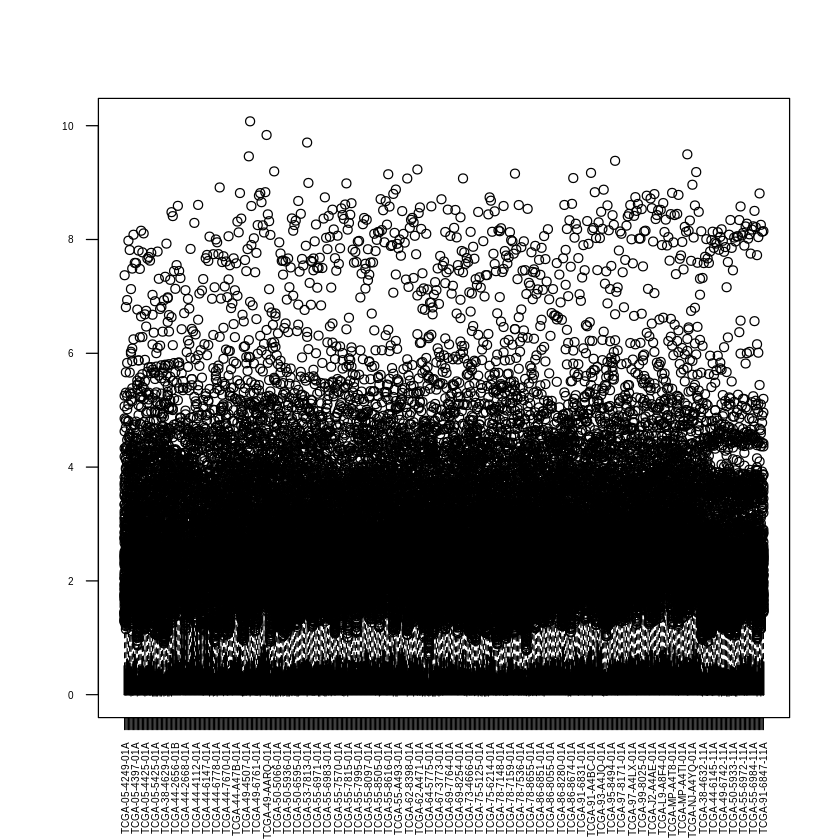

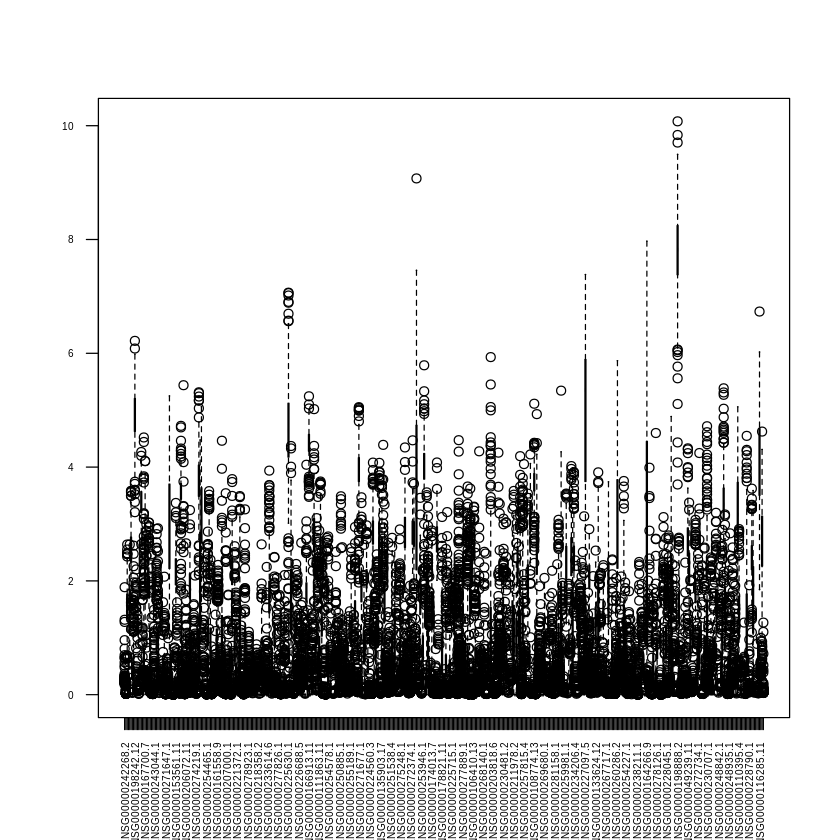

In [199]:
first_500 <- exp[,1:500]

tpose_mat <- t(first_500)
boxplot(tpose_mat, cex.axis=0.5, las=2)

boxplot(first_500, cex.axis=0.5, las=2)

**Exploratory Data Analysis**

PCA is one of dimensionality reduction method & an exploratory data analysis method, which give us an idea regarding variability & patterns in the data.

Ideally, PCA is performed on normalized data, since, our data is already log scaled (although yet to normalize) transformed. To get an idea, we will perform PCA before and after normalization. 

Here, we will perform PCA with `prcomp` functiona and subsequently,  draw scatetrplot with PC1 and PC2 using `ggfortify` package

Install packages for PCA plots

In [5]:
install.packages("ggfortify")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’




Load library

In [6]:
library(ggfortify)

Loading required package: ggplot2



Create PCA objects

In [ ]:
#PCA object
pca_res <- prcomp(exp)

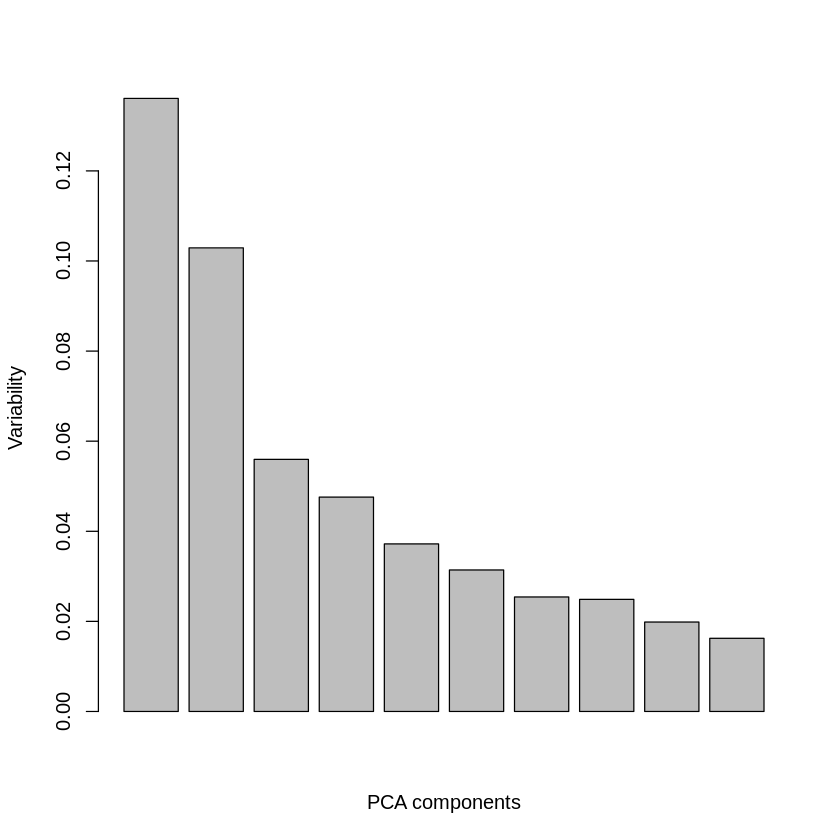

In [ ]:
#extract variance explained by PCA componnents
var_explained <- pca_res$sdev^2/sum(pca_res$sdev^2)

#barplot for first 10 components
barplot(var_explained[1:10], xlab="PCA components", ylab="Variability")

**Tissue type PCA plot**

First, let draw PCA plot based on tissue type, i.e. Cancer & Normal. Here, we will assign color using the `colour= tissue_type `information available in our clinical data/full data

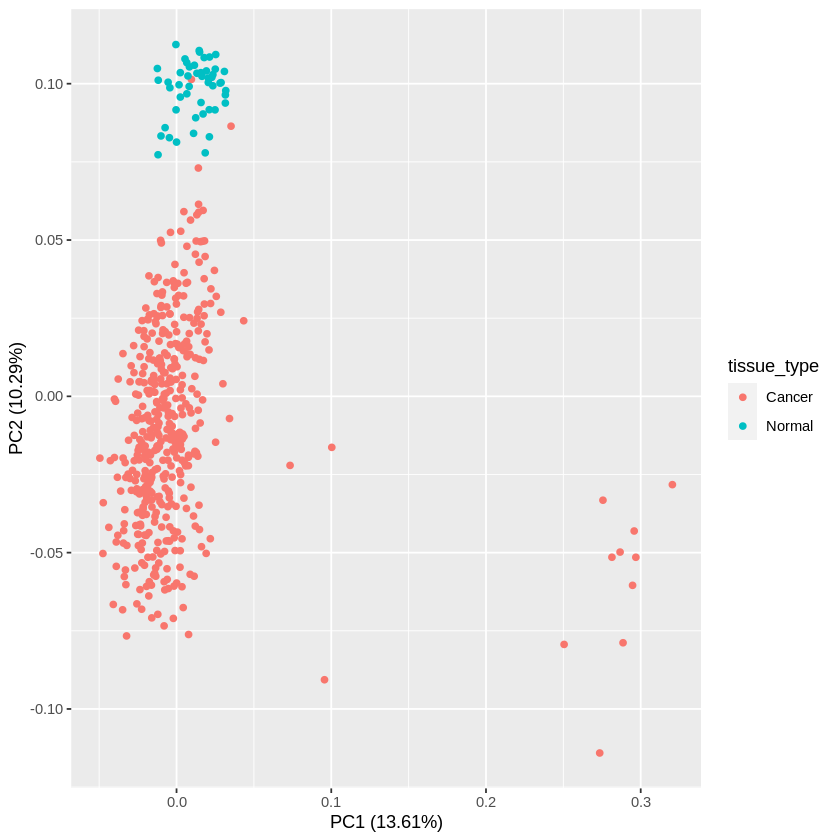

In [ ]:
autoplot(pca_res, data=full_data, colour="tissue_type")


The PCA plot based on Tissue type indicates the clear distinction between Cancer and Normal samples. Besides, it also showing some of the outliers, we can remove them after their identification.
Since, we performed PCA on only log-transformed data, thus we need to check PCA results on normalized data as well. We perform PCA with normalized data as well to make sure we have outliers in the data (We will do it later). Before that, let's explore PCA plot for other clinical characteristics, i.e. gender, stage, vital status etc. 

**PCA plot for gender**

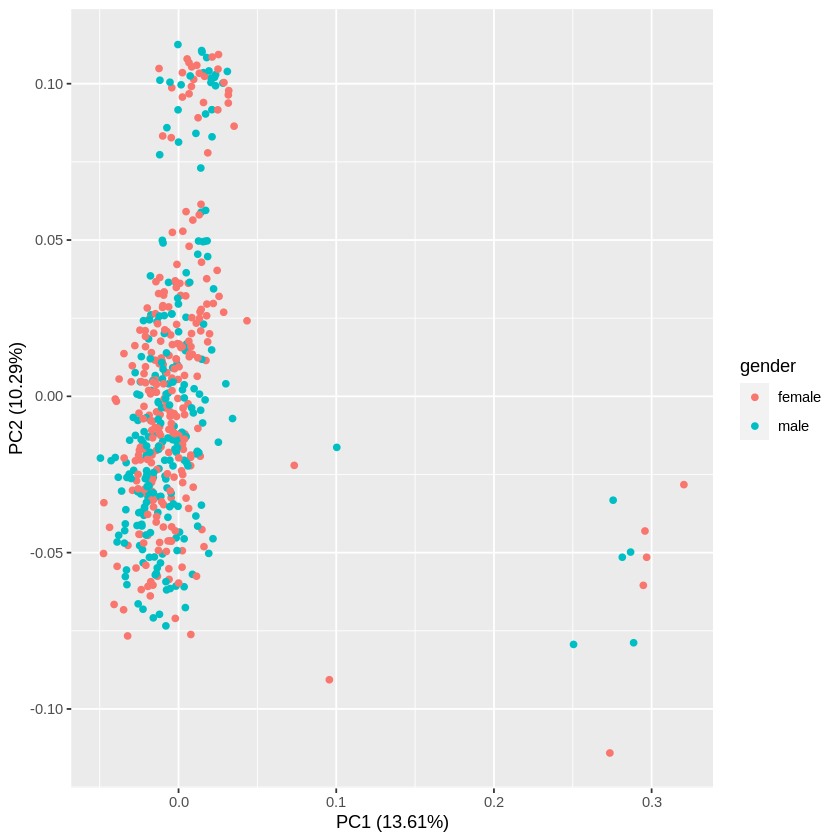

In [ ]:
autoplot(pca_res, data=full_data, colour="gender")

**PCA plot for tumor stage**

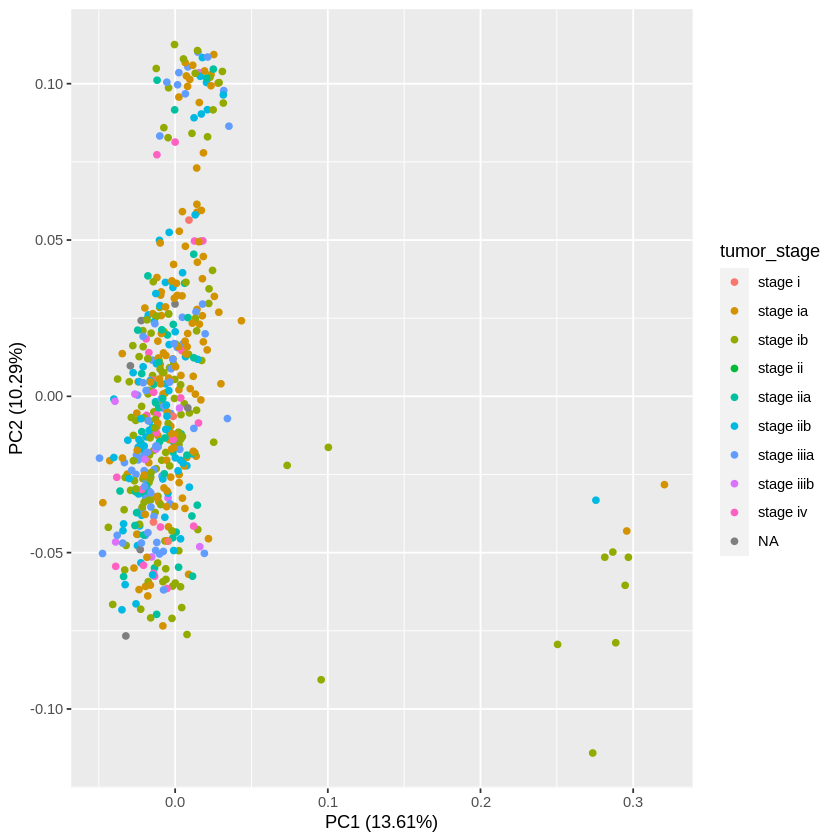

In [ ]:
autoplot(pca_res, data=full_data, colour="tumor_stage")

**PCA plot for vital status**

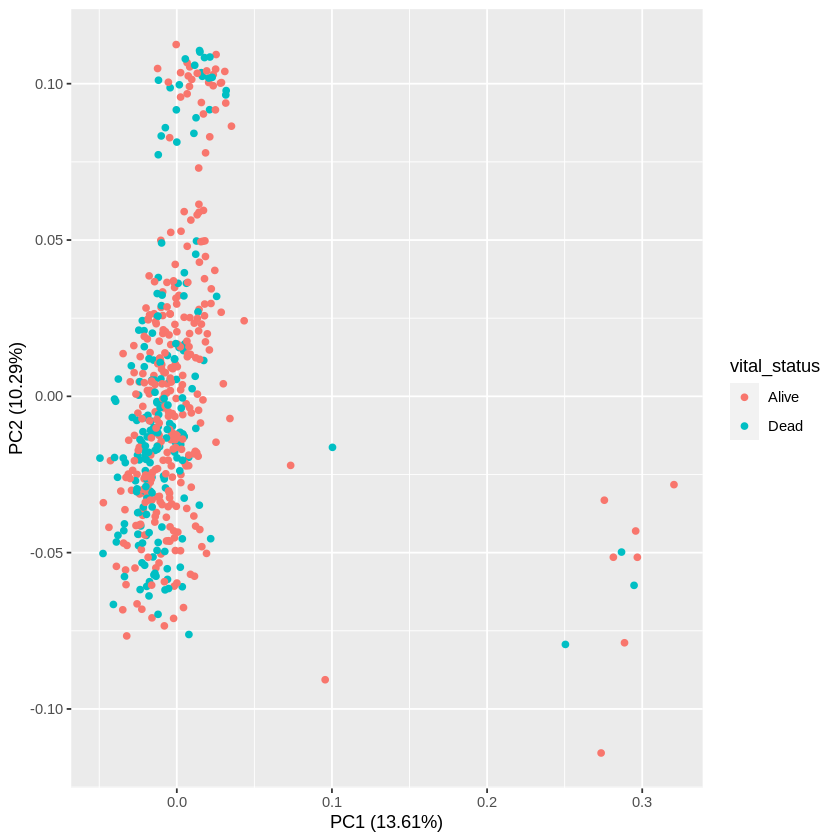

In [ ]:
autoplot(pca_res, data=full_data, colour="vital_status")

PCA plots have not shown any clear distict pattern for tumor stage, gender, vital status, etc.

This also indicate classifying these conditions based on molecular (transcriptomics) data is itself challenging task. Thus, we need specific molecular signatures that can stratify these groups.

**Data Maniputaion**

Many a times, we need to modify data/column names for analysis. Here, we are going to change some of the names in clinical data for better reprsentaion.  e.g. Replacing multiple stages names with single string for stages, e.g. Stage 1A, stage 1B, Stage 1 as Stage_1

For this purpose, we will use `recode` function of the `car` package

In [7]:
#install packages
install.packages("car")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’




In [8]:
#load library
library(car)

Loading required package: carData



Change names/value in data. Here, we will create extra columns with new names keeping original names in data

In [9]:
clin$OS <- recode(clin$vital_status,"c('Dead')=1;c('Alive')=0")

clin$stage <- recode(clin$tumor_stage,"c('stage ia','stage ib','stage i')='Stage_1';c('stage iia','stage iib','stage ii')='Stage_2';c('stage iiia','stage iiib','stage iii')='Stage_3'; c('stage iv')='Stage_4'")

clin$class <- recode(clin$tumor_stage,"c('stage ia','stage ib','stage i')=1;c('stage iia','stage iib','stage ii')=2; c('stage iiia','stage iiib','stage iii')=3; c('stage iv')= 4")


Combine clinical data (conatining new columns) with expression data. Here, we are combining both data column-wise using `cbind`

In [10]:
Full_data1 <- cbind(clin, exp)

To make sure, new column added in clinical data; let's draw PCA plot with new column `stage`

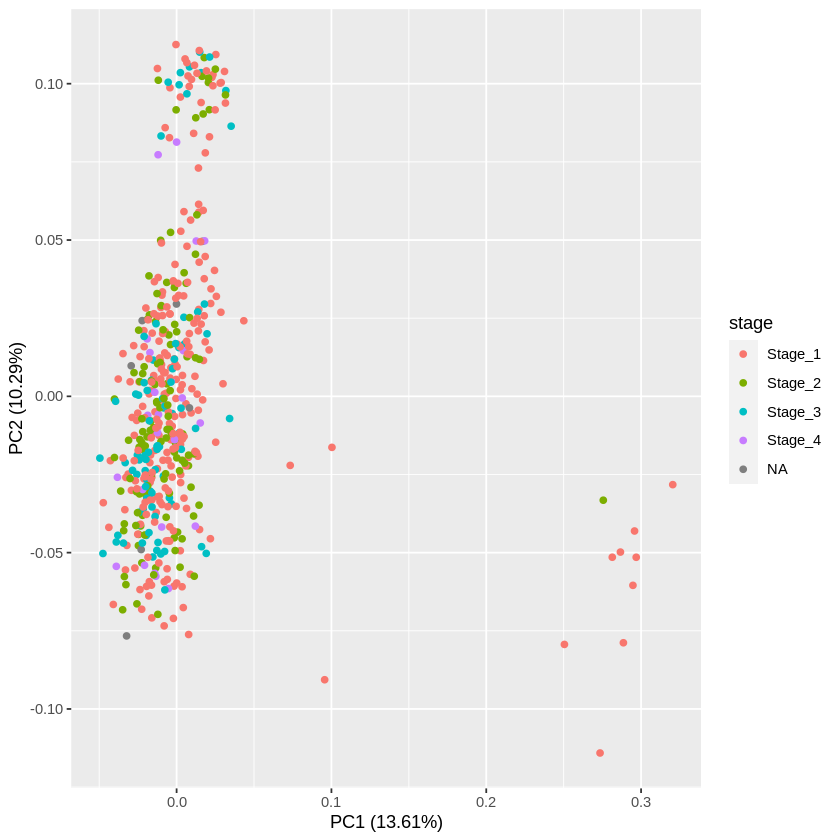

In [ ]:
autoplot(pca_res, data=Full_data1, colour="stage")

**Data preparation & Normalization for Analysis**

We can apply machine learning and statiscal analytical methods primarily on normalized data.
But, before normalization, we must prepare our data properly. Here, we will prepare our training and test data.

**Training data** will be used for used feature selection/feature reduction and to train the models.

**Test data** will be used assess the performance of prediction model devevloped based on identified molecular signatures.


Since, in this analysis, our goal is to identify prognostic signature/predictor for LUAD cancer.

From the previous literature it is known that tumor stage is the key factor which plays a vital role in the prognosis of patients. Thus, first, we will prepare training and test dataset based on tumor stage.

80% data from each stage will be included in training data
and 20% data will be included in test data.

Besides, exploratory data analysis using PCA (see PCA plot based on stage) shows that there are some samples where we have no information (NA)regarding tumor stage. Thus, we considering only stage_1, stage_2 , stage_3 and stage_4 samples.

**Extract data for each stage**

In [11]:
# Extract data for each stage
stage1 = subset(Full_data1, stage == "Stage_1")
stage2 = subset(Full_data1, stage == "Stage_2")
stage3 = subset(Full_data1, stage == "Stage_3")
stage4 = subset(Full_data1, stage == "Stage_4")

#Check dimensions of extracted data
dim(stage1)
dim(stage2)
dim(stage3)
dim(stage4)

[1]   267 60499

[1]   122 60499

[1]    85 60499

[1]    24 60499

**Prepare training (80%) and test (20%) data for each stage independently**

In [12]:
set.seed(7)
#Split training and test data into 80:20 ratio 
dt1 = sort(sample(nrow(stage1), nrow(stage1)*.8))

#Training Data
train_s1<-stage1[dt1,]

#Test Dataset
test_s1<-stage1[-dt1,]

#Split training and test data into 80:20 ratio 
dt2 = sort(sample(nrow(stage2), nrow(stage2)*.8))

#Training Data
train_s2<-stage2[dt2,]

#Test Dataset
test_s2<-stage2[-dt2,]


#Split training and test data into 80:20 ratio 
dt3 = sort(sample(nrow(stage3), nrow(stage3)*.8))

#Training Data
train_s3<-stage3[dt3,]

#Test Dataset
test_s3<-stage3[-dt3,]


#Split training and test data into 80:20 ratio 
dt4 = sort(sample(nrow(stage4), nrow(stage4)*.8))

#Training Data
train_s4<-stage4[dt4,]

#Test Dataset
test_s4<-stage4[-dt4,]


# final train and test

train_set <- rbind(train_s1, train_s2, train_s3, train_s4)

test_set <- rbind(test_s1, test_s2, test_s3, test_s4)


#Write into files
write.table(train_set, file = "train_set.txt", sep="\t", quote=F, row.names = F)

write.table(test_set, file = "test_set.txt", sep="\t", quote=F, row.names = F)

**Extract clinical data for training and test**

In [13]:
#Extract clinical data for training and test
train_clin <- train_set[,1:16]
test_clin <- test_set[,1:16]

#View top rows
head(train_clin[1:16],5)

,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,days_to_last_follow_up,tumor_stage,cigarettes_per_day,tumor_stage.1,OS,stage,class
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
TCGA-05-4249-01A,TCGA-05-4249,Cancer,67,NA,male,NA,Alive,1523,NA,1523,stage ib,2.8493151,stage ib,0,Stage_1,1
TCGA-05-4382-01A,TCGA-05-4382,Cancer,68,NA,male,NA,Alive,607,NA,607,stage ib,3.3972603,stage ib,0,Stage_1,1
TCGA-05-4389-01A,TCGA-05-4389,Cancer,70,NA,male,NA,Alive,1369,NA,1369,stage ia,2.3561644,stage ia,0,Stage_1,1
TCGA-05-4390-01A,TCGA-05-4390,Cancer,58,NA,female,NA,Alive,1126,NA,1126,stage ib,0.8219178,stage ib,0,Stage_1,1
TCGA-05-4420-01A,TCGA-05-4420,Cancer,41,NA,male,NA,Alive,912,NA,912,stage ib,2.0821918,stage ib,0,Stage_1,1


Extract only expression data for training and test data (which is required for normalization

In [14]:
#extract only expression values
train_exp <- train_set[17:ncol(train_set)]
test_exp <- test_set[17:ncol(test_set)]

#Check dimensions
dim(train_exp)
dim(test_exp)

[1]   397 60483

[1]   101 60483

#Data Pre-processing & Normalization
It is important to remove those features (genes) from data that contribute only noise
Thus, we will remove those genes having zero value and equal variance in 80% of samples using `NZV` method from `caret` package and `predict` function used for predicting values for training and test data


Next, we will normalize our training and test data with center and scale methods. Eventually, we will obtain zscore normalized data


In [15]:
#install caret package
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’




In [18]:
#load library
library("caret")

In [19]:
# remove near zero variation for the columns at least or 80% of the values are the same
# this function creates the filter 
nzv <- preProcess(train_exp,method="nzv",uniqueCut = 20)

# apply the above created filter using "predict" function
nzv_exp_tr <- predict(nzv,train_exp)
nzv_exp_te <- predict(nzv,test_exp)

# center & scaling
processCenter <- preProcess(nzv_exp_tr, method = c("center", "scale"))

# apply center & scaling on traning and test data
Norm_tr_exp <- predict(processCenter,nzv_exp_tr)
Norm_te_exp <- predict(processCenter,nzv_exp_te)

#round up value upto 3 digits
Norm_tr_exp <- round(Norm_tr_exp,3)
Norm_te_exp <- round(Norm_te_exp,3)

In [20]:
#check dimension of normalized data
dim(Norm_tr_exp)
dim(Norm_te_exp)

[1]   397 39482

[1]   101 39482

In [21]:
train_set1 <- cbind(train_clin, Norm_tr_exp )
test_set1 <- cbind(test_clin, Norm_te_exp )

Visualization of data

In [ ]:
head(Norm_tr_exp[1:10],5)

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000078237.5,ENSG00000146083.10,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,ENSG00000231981.3,ENSG00000134108.11
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-05-4249-01A,-0.157,-0.021,-0.903,-0.293,0.623,-0.039,0.346,-0.068,-0.121,-0.619
TCGA-05-4382-01A,-0.362,-0.222,-0.071,0.774,-0.714,-0.490,0.219,-0.353,-0.157,0.238
TCGA-05-4389-01A,-0.481,0.051,0.010,0.991,-0.372,-0.041,0.927,-0.362,-0.250,-0.527
TCGA-05-4390-01A,-0.481,-0.089,-1.316,0.382,-0.234,-0.631,0.616,-0.367,-0.250,0.082
TCGA-05-4420-01A,-0.481,-0.172,-1.475,1.784,-0.810,0.085,0.742,-0.234,-0.250,0.072


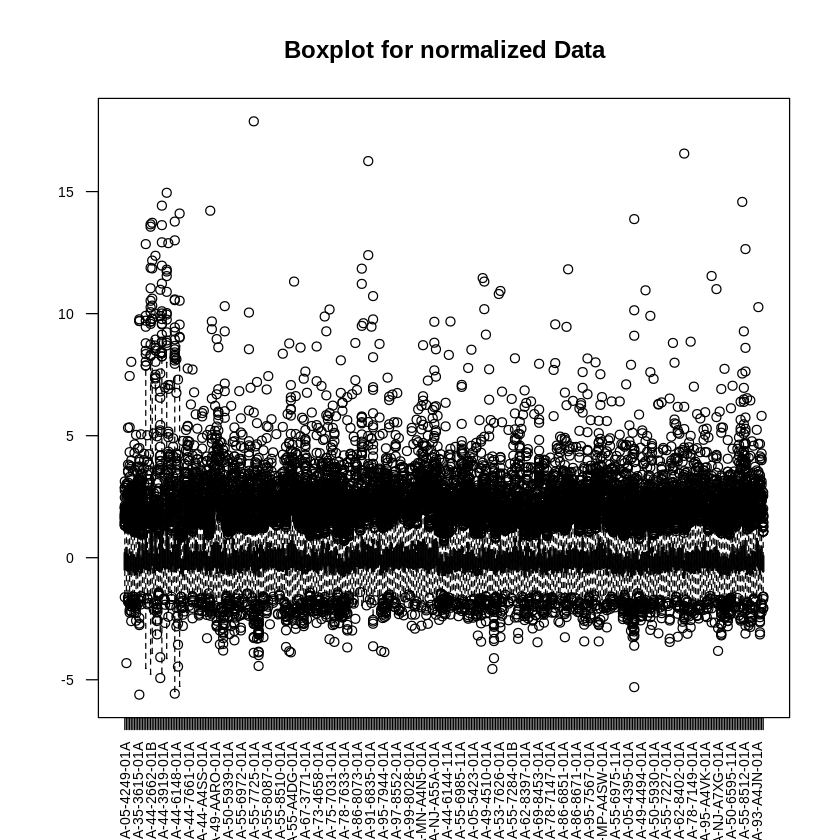

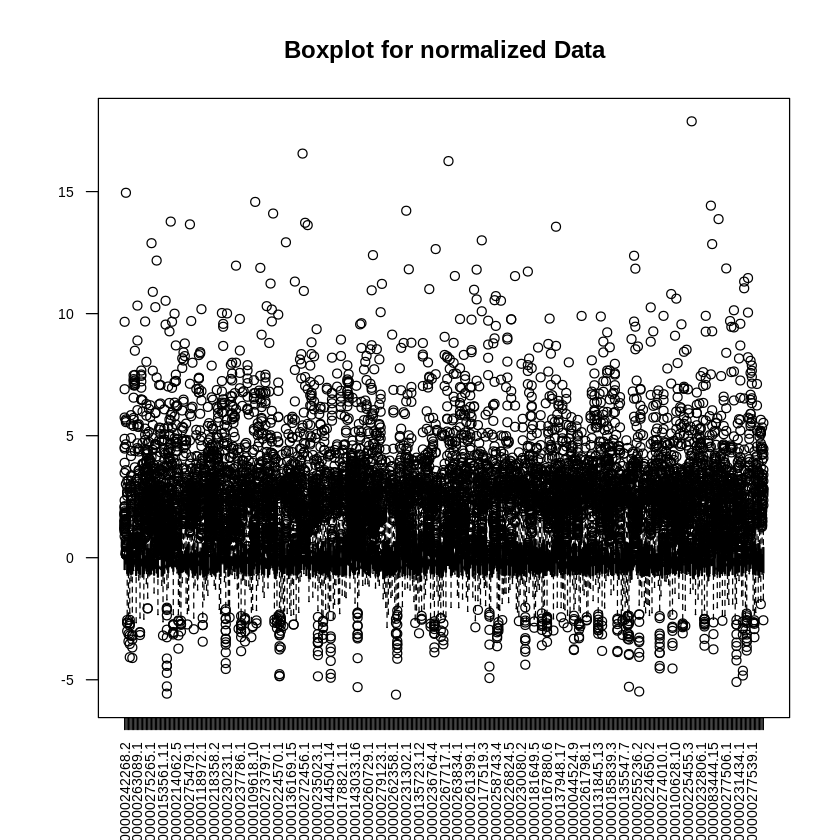

In [ ]:
### Visulization
Norm_exp_t <- t(Norm_tr_exp[1:500])

boxplot(Norm_exp_t, las=2, cex.axis=0.7, main="Boxplot for normalized Data")

boxplot(Norm_tr_exp[1:500], las=2, cex.axis=0.7, main="Boxplot for normalized Data")

**PCA - Exploratory Data analysis after Data Normalization**

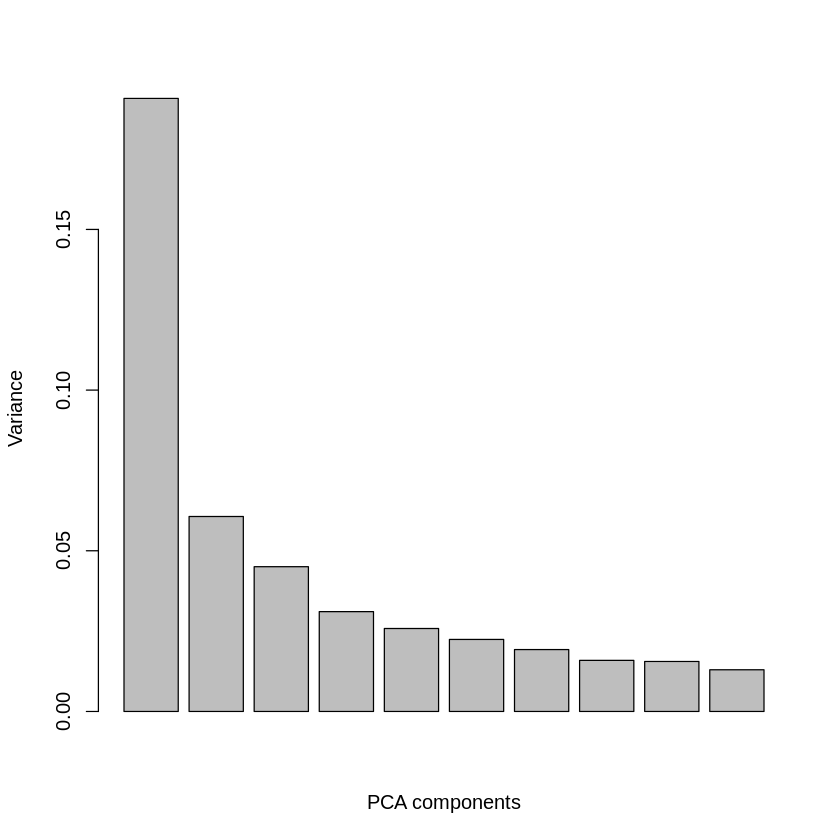

In [22]:
#PCA for pre-processed data
pca_res1 <- prcomp(Norm_tr_exp)

#variance explained by PCA components
var_explained1 <- pca_res1$sdev^2/sum(pca_res1$sdev^2)

#barplot for first 10 components
barplot(var_explained1[1:10], xlab="PCA components", ylab="Variance")

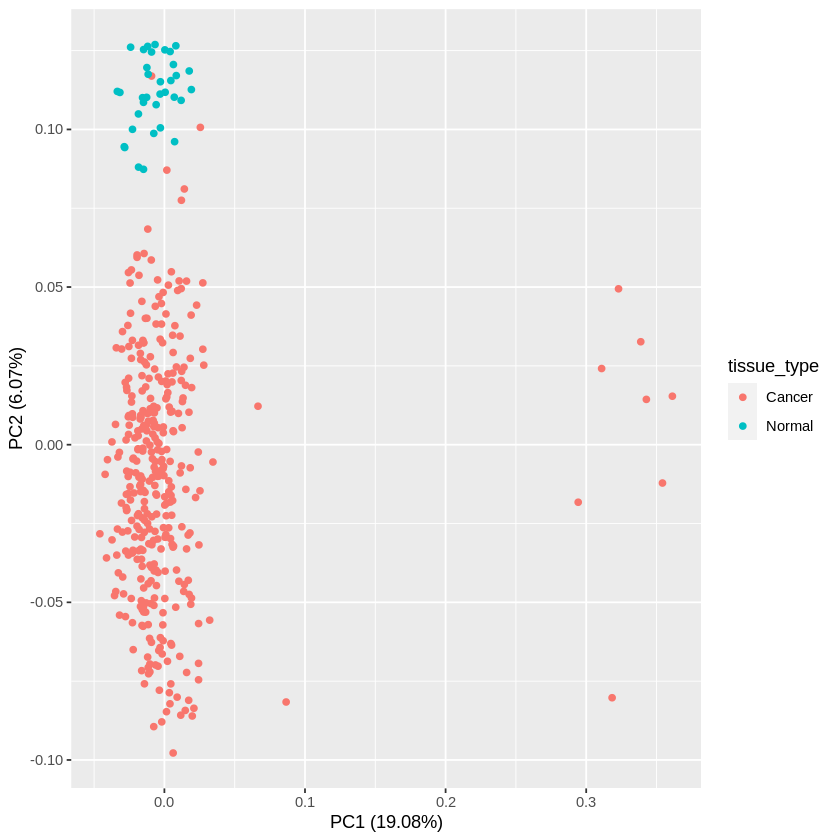

In [ ]:
autoplot(pca_res1, data=train_set, colour="tissue_type")

PCA plot based on normalized data showing the better separation and PC1 and PC2 reprsents more variability, i.e., ~25%.
But, still it showing outliers (on the right side).  Next, let's identify these outliers

**Identify outlier samples**

To identify outleir samples, we can label samples  using `label=TRUE`

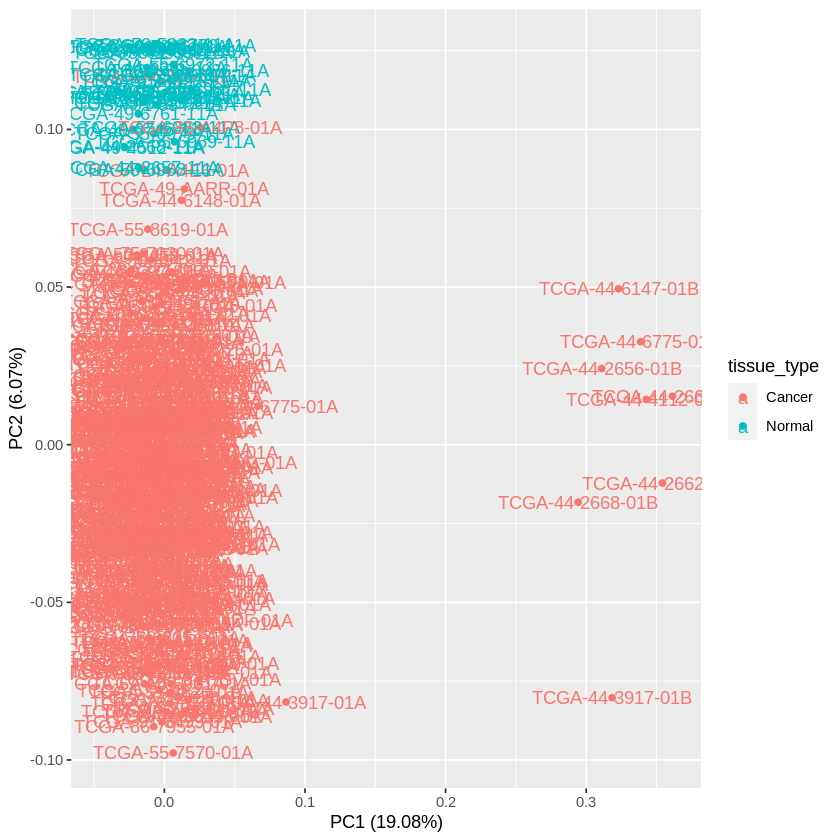

In [ ]:
autoplot(pca_res1, data=train_set, colour="tissue_type", label=TRUE)

On assessing these outliers, it has been observed that these samples ID names ends with -01B or -01C; which represent different vials for samples from the same site.

This also indicate, handling of data extraction or sample extraction can impact the analysis



**Find the index (row number) for outliers**

To Remove the outliers , next, we will identify the index (row number) with sample ID using `which` function



In [23]:
#get row index
which(rownames(train_set1) %in% c("TCGA-44-3917-01B", "TCGA-44-2668-01B", "TCGA-44-2662-01B","TCGA-44-2656-01B", "TCGA-44-6146-01B", "TCGA-44-6147-01B","TCGA-44-6775-01C", "TCGA-55-7284-01B", "TCGA-44-4112-01B","TCGA-44-2666-01B" , "TCGA-55-7913-01B" ))


[1]  14  17  18  20  24  27  32  35  87 241

**Remove outliers** 

Here, we will remove outlier samples using index values

In [24]:
# drop row with row index 
train_set2 <- train_set1[-c(14, 17, 18, 20, 24, 27, 32,35, 87, 241),]
#train_set2<- train_set1[row.names(train_set1) != "TCGA-44-3917-01B" ,"TCGA-44-2668-01B" , drop = FALSE]
dim(train_set1)
dim(train_set2)

[1]   397 39498

[1]   387 39498

**PCA after outlier removal**

In [ ]:
data_pca <- train_set2[17:ncol(train_set2)]

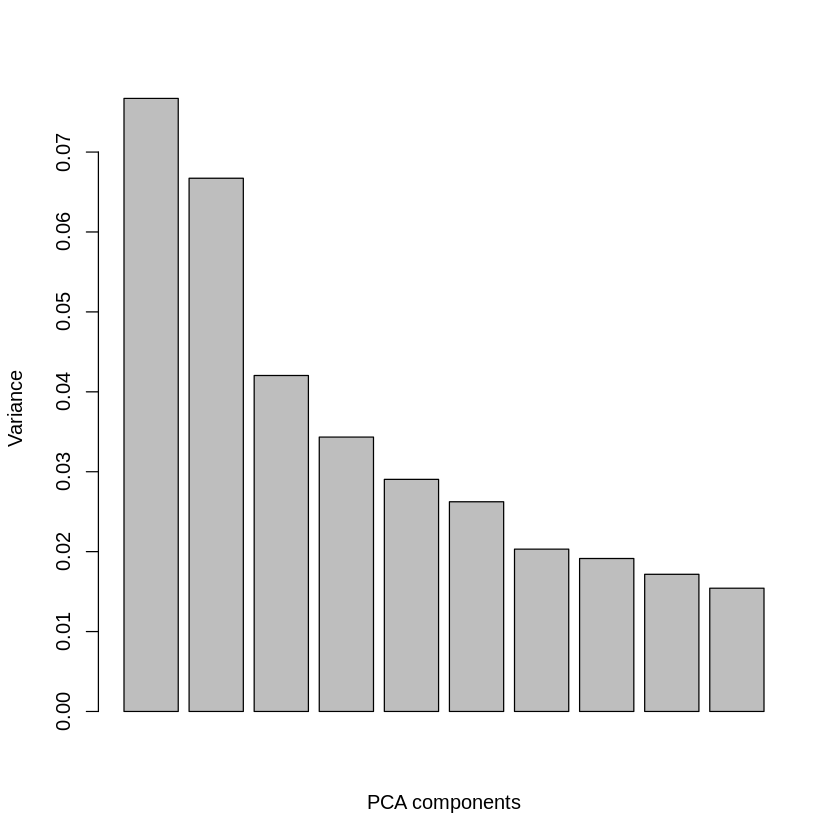

In [ ]:
#PCA for pre-processed data
pca_res2 <- prcomp(data_pca)

#variance explained by PCA components
var_explained2 <- pca_res2$sdev^2/sum(pca_res2$sdev^2)

#barplot for first 10 components
barplot(var_explained2[1:10], xlab="PCA components", ylab="Variance")


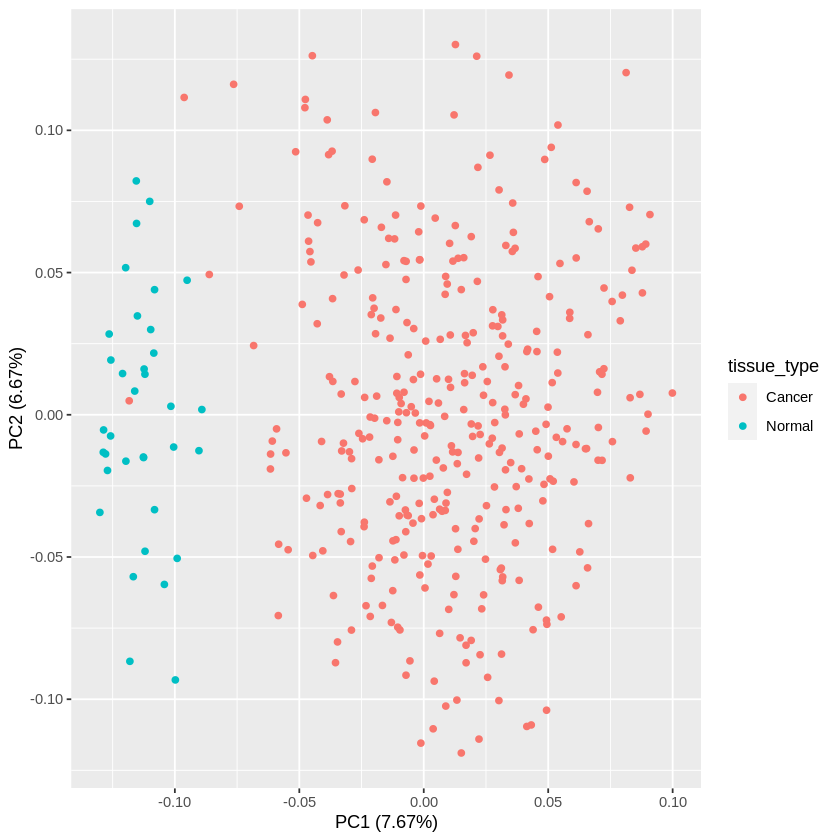

In [ ]:
autoplot(pca_res2, data=train_set2, colour="tissue_type")

After outliers removal, we can clearly see the distict pattern in cancer and normal samples Now, our training data is ready for downstream analysis.


In [ ]:
dim(train_set2)

[1]   387 39498

**Feature selection**

In our training data, we still have more than 39K features or RNA transcripts. To develop a good prediction model, we must must have only important features, other will results only in noise. Besides, ML prediction models based on large number of features usually computationally very expensive.

Thus, it is important to consider only relevant features in ML based biomedical data analysis. There are number of approaches that can be used to identify relevant features.

Let's first apply simplest approach, i.e. significantly differentially expressed genes between cancer and normal or non-tumorous samples. Since, we are looking for prognostic signatures for LUAD patients, thus genes that similarly expressed between cancer and normal definitly not relevant.

**Differential Gene Expression Analysis**

There are number of methods, i.e. Wilcoxon T-test, DESeq2, EdgeR, Limma that can be used to identify differentially expressed genes. Choice of method would be based on  type of values in the data. For instance, DESeq2 and EdgeR can be applied on non-normalized data Raw read count data, Limma can used for microarray data.  Wilcoxon and Welch tests can applied on normalized data.

Since, our data is already Zscore- normalized , thus we can apply directly wilcoxon ranking test.

**Prepare data for Wilcoxon ranking T-test**
Since, we want to identify significantly differentially expressed genes between cancer and normal samples.
Now, let's extract data for cancer and normal samples.
We added Cancer and normal information based on TCGA barcode ID.

In [25]:
#Prepare groups
group1 = subset(train_set2, tissue_type== "Cancer")
group2 = subset(train_set2, tissue_type== "Normal")

dim(group1)
dim(group2)


[1]   352 39498

[1]    35 39498

In [26]:
head(group1[17:20],5)

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000078237.5
,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-05-4249-01A,-0.157,-0.021,-0.903,-0.293
TCGA-05-4382-01A,-0.362,-0.222,-0.071,0.774
TCGA-05-4389-01A,-0.481,0.051,0.010,0.991
TCGA-05-4390-01A,-0.481,-0.089,-1.316,0.382
TCGA-05-4420-01A,-0.481,-0.172,-1.475,1.784


In [27]:
#combine cancer & Normal
C_N_data <- rbind(group1[17:ncol(group1)], group2[17:ncol(group2)])

#prepare t_test input
t_test_input <- t(C_N_data)

dim(t_test_input)

#view first 5 rows of the data
head(t_test_input,5)

#Extract feature names
genes <- row.names(t_test_input)

[1] 39482   387

,TCGA-05-4249-01A,TCGA-05-4382-01A,TCGA-05-4389-01A,TCGA-05-4390-01A,TCGA-05-4420-01A,TCGA-05-4426-01A,TCGA-05-4433-01A,TCGA-05-5715-01A,TCGA-35-3615-01A,TCGA-38-4630-01A,⋯,TCGA-44-3396-11A,TCGA-49-4512-11A,TCGA-49-6743-11A,TCGA-49-6745-11A,TCGA-49-6761-11A,TCGA-50-5933-11A,TCGA-50-5936-11A,TCGA-50-6595-11A,TCGA-55-6981-11A,TCGA-55-6968-11A
ENSG00000242268.2,-0.157,-0.362,-0.481,-0.481,-0.481,-0.481,-0.149,-0.481,-0.481,-0.036,⋯,0.297,-0.481,0.112,-0.199,-0.481,-0.235,0.106,0.181,1.831,-0.130
ENSG00000270112.3,-0.021,-0.222,0.051,-0.089,-0.172,-0.122,-0.222,-0.073,-0.222,0.736,⋯,-0.166,-0.085,-0.222,-0.222,-0.222,-0.222,-0.222,-0.222,0.141,-0.076
ENSG00000167578.15,-0.903,-0.071,0.010,-1.316,-1.475,-1.879,-0.036,-0.988,0.130,-0.305,⋯,-0.177,0.162,-0.410,0.513,0.527,-0.282,-0.311,-0.044,0.626,1.005
ENSG00000078237.5,-0.293,0.774,0.991,0.382,1.784,-0.556,0.006,0.372,0.663,-0.875,⋯,0.279,-0.127,0.212,-0.119,0.143,-0.114,-0.202,-0.562,-0.158,0.389
ENSG00000146083.10,0.623,-0.714,-0.372,-0.234,-0.810,2.922,0.658,-1.522,0.829,2.379,⋯,-0.373,-3.183,-1.268,-2.271,-0.251,-1.074,-0.328,-0.070,0.045,-0.549


In [28]:
dim(t_test_input)

[1] 39482   387

Apply Wilcoxon test on data between cancer & Normal samples

In [29]:
Wilcoxon <- apply(t_test_input[,1:ncol(t_test_input)], 1, function (x) wilcox.test(x[1:352],x[353:387],paired=F))

Extract p-values, FDR, Fold change(FC), Bonferroni adjusted p-value from the results

In [30]:
#Extract P-values
p_value_w <- unlist(lapply(Wilcoxon, function(x) x$p.value))

#Extract FDR
fdr_w <- p.adjust(p_value_w, method = "fdr")

#Extract Boneferroni adjusted P-values
boneferroni_w <- p.adjust(p_value_w, method = "bonferroni")

#Make list
list_w <- Map(c, p_value_w, fdr_w, boneferroni_w)

#make dataframe of the list
result_w<- data.frame(matrix(unlist(list_w), nrow=length(list_w), byrow=T))

#calculate the mean of each gene per cancer group group
cancer = apply(t_test_input[,1:352], 1, mean)

#calcuate the mean of each gene per normal group
normal = apply(t_test_input[, 353:387], 1, mean) 

foldchange <- as.data.frame(cancer/normal)

#Combine with the gene
result_w1 <-cbind(genes,result_w,foldchange )

#Provide the column names to both groups
colnames(result_w1) <- c("Gene_ID","P_value","FDR","Boneferroni", "FC")

Print top rows for t-test results

In [31]:
head((result_w1))

,Gene_ID,P_value,FDR,Boneferroni,FC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268.2,ENSG00000242268.2,2.525109e-04,6.705431e-04,1.000000000,-0.17799950
ENSG00000270112.3,ENSG00000270112.3,5.157752e-01,5.905643e-01,1.000000000,0.57607209
ENSG00000167578.15,ENSG00000167578.15,7.957472e-02,1.192866e-01,1.000000000,0.02341928
ENSG00000078237.5,ENSG00000078237.5,7.742810e-01,8.200371e-01,1.000000000,-0.01455999
ENSG00000146083.10,ENSG00000146083.10,7.685919e-08,3.622551e-07,0.003034555,-0.12981270
ENSG00000158486.12,ENSG00000158486.12,7.519329e-01,8.012259e-01,1.000000000,-0.16773946


**Identification significantly differentially expressed genes**

first Sort results based on FDR value using `order `function. Here, I am using FDR < 0.05 to identify significant genes.

Further, applying Fold change criteria  FC >= +1.2 and FC< = -1.2 for identification of upregulated genes and downregulated genes, respectively.


In [32]:
# Sort features based on FDRy value
sorted_features <- as.data.frame(result_w1[order(result_w1[,"FDR"], decreasing =  FALSE),])
 
#select significant features based on FDR <0.05
sig_features <- sorted_features[sorted_features$FDR < 0.05, ]

#select top features based on FDR <0.05 & FC > +/- 1.2
# upregulated genes
upreg_features <- sig_features[sig_features$FC > 1.2, ]

#upregulated genes
downreg_features <- sig_features[sig_features$FC < -1.2, ]

#Check dimensions
dim(upreg_features)
dim(downreg_features)

#Create top feature combining both significantly upregulated and downregulated genes
top_features <- rbind(upreg_features,downreg_features)
dim(top_features)

#Write results into a file
write.table(top_features,file="significant_gene_result.txt", sep='\t',  quote = F,row.names = FALSE)

#view top rows for results
head(top_features)

[1] 263   5

[1] 331   5

[1] 594   5

,Gene_ID,P_value,FDR,Boneferroni,FC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000250280.2,ENSG00000250280.2,1.047854e-11,8.902812e-11,4.137137e-07,251.988636
ENSG00000181541.5,ENSG00000181541.5,5.349235e-10,3.488578e-09,2.111985e-05,3.891182
ENSG00000251011.4,ENSG00000251011.4,9.916718e-10,6.227642e-09,3.915319e-05,7.346728
ENSG00000235731.1,ENSG00000235731.1,1.195481e-09,7.421380e-09,4.719997e-05,4.649381
ENSG00000169836.4,ENSG00000169836.4,1.280548e-09,7.909669e-09,5.055861e-05,2.397145
ENSG00000259379.1,ENSG00000259379.1,6.498357e-09,3.606018e-08,2.565682e-04,5.046939


From the Differentially Gene expression analysis, we are left with few hundered important features  from 39K.
Now, we can use these features for downstream analysis


Volcano plot

In [33]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Warning message in log(FC):
“NaNs produced”
Warning message in log(FC):
“NaNs produced”
Warning message:
“Removed 19286 rows containing missing values (geom_point).”


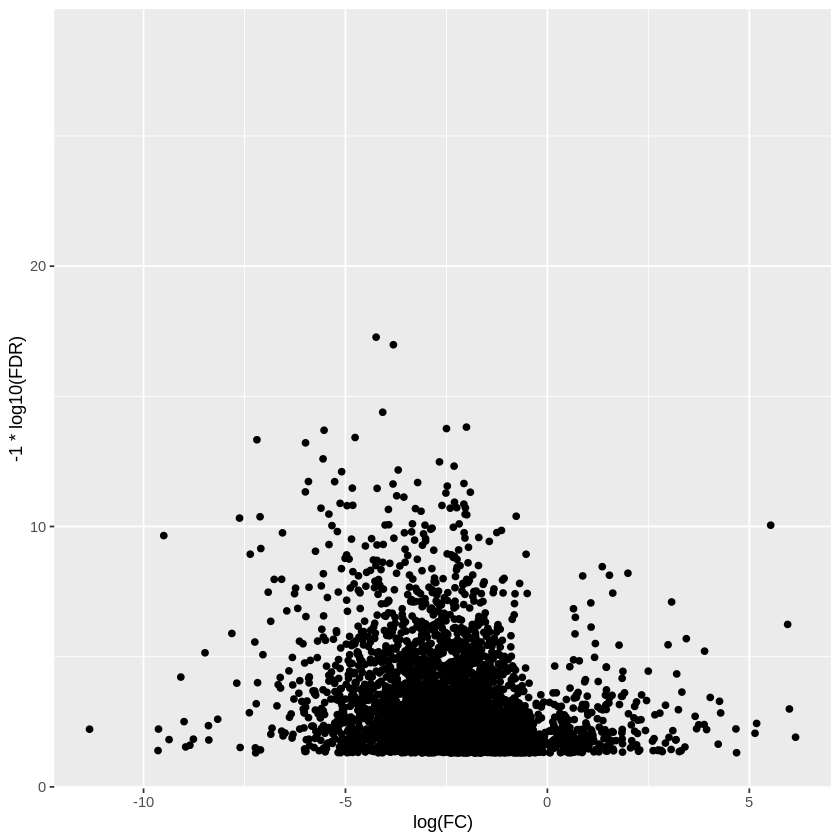

In [34]:
library(ggplot2)
volcano = ggplot(data = sig_features, aes(x = log(FC), y = -1*log10(FDR)))
volcano + geom_point()

**Create Training and test data with selected features only**


In [35]:
#Prepare dataset (training/test) for selected only
top1 <- as.data.frame(top_features$Gene_ID)
colnames(top1) <- c("ID")
#head(top1)

#Transpose training and test data to extract genes
train_set2_t <- t(train_set2)
test_set1_t <- t(test_set1)

# Prepare training data with only selected top features
tr_selected_data <- as.data.frame(train_set2_t[row.names(train_set2_t) %in% c(top1$ID), ])


# Prepare test data with only selected top features
te_selected_data <- as.data.frame(test_set1_t[row.names(test_set1_t) %in% c(top1$ID), ])

#Check dimensions of dataset
dim(tr_selected_data)
dim(te_selected_data)

[1] 594 387

[1] 594 101

In [36]:
head(tr_selected_data,5)
head(te_selected_data,5)

,TCGA-05-4249-01A,TCGA-05-4382-01A,TCGA-05-4389-01A,TCGA-05-4390-01A,TCGA-05-4420-01A,TCGA-05-4426-01A,TCGA-05-4433-01A,TCGA-05-5715-01A,TCGA-35-3615-01A,TCGA-38-4630-01A,⋯,TCGA-73-4666-01A,TCGA-73-4670-01A,TCGA-78-7145-01A,TCGA-78-7160-01A,TCGA-78-7167-01A,TCGA-93-A4JN-01A,TCGA-93-A4JP-01A,TCGA-97-8171-01A,TCGA-99-8033-01A,TCGA-55-6968-11A
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000259883.1,-0.068,-0.353,-0.362,-0.367,-0.234,-0.290,0.491,-0.348,-0.457,-0.254,⋯,-0.459,0.143,-0.159,-0.382,-0.144,-0.309,0.028,-0.522,-0.057,-0.522
ENSG00000231981.3,-0.121,-0.157,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.144,-0.250,⋯,-0.250,-0.250,-0.250,-0.250,-0.144,-0.250,0.060,-0.250,-0.250,0.025
ENSG00000263089.1,-0.085,-0.468,-0.491,-0.472,-0.320,-0.334,1.369,-0.423,-0.283,-0.429,⋯,-0.322,-0.456,-0.417,-0.476,0.220,0.013,-0.084,-0.106,-0.118,-0.051
ENSG00000233540.1,1.450,0.129,-0.040,-0.455,-0.455,-0.455,-0.455,0.431,-0.455,0.376,⋯,-0.128,-0.455,1.357,-0.455,-0.117,-0.455,-0.455,-0.455,-0.095,-0.455
ENSG00000273797.1,-0.353,-0.192,-0.288,-0.417,-0.369,-0.056,-0.287,-0.276,-0.161,-0.120,⋯,-0.315,-0.159,-0.219,-0.195,0.068,0.338,-0.116,-0.131,-0.198,-0.149


,TCGA-05-4417-01A,TCGA-05-4422-01A,TCGA-35-4122-01A,TCGA-38-4625-01A,TCGA-38-4631-01A,TCGA-44-2657-01A,TCGA-44-2666-01A,TCGA-44-5645-01B,TCGA-44-7671-01A,TCGA-44-7672-01A,⋯,TCGA-97-8547-01A,TCGA-99-8025-01A,TCGA-MP-A4T6-01A,TCGA-MP-A4T9-01A,TCGA-50-5930-11A,TCGA-78-7156-01A,TCGA-86-7701-01A,TCGA-L9-A5IP-01A,TCGA-MP-A4T7-01A,TCGA-38-4632-11A
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000259883.1,-0.089,-0.267,-0.244,-0.211,-0.522,0.063,2.793,8.409,-0.382,-0.343,⋯,0.116,0.002,0.087,0.494,-0.366,-0.388,-0.034,0.290,0.134,-0.180
ENSG00000231981.3,-0.008,-0.250,-0.250,-0.250,-0.250,-0.250,3.460,7.998,-0.250,-0.250,⋯,-0.250,0.127,-0.100,-0.250,-0.250,-0.033,-0.250,-0.090,-0.250,-0.250
ENSG00000263089.1,-0.398,-0.051,-0.512,-0.458,-0.467,-0.394,1.898,6.165,-0.405,-0.398,⋯,0.066,-0.334,0.808,-0.356,-0.012,0.012,-0.195,-0.412,-0.262,-0.467
ENSG00000233540.1,-0.455,-0.455,-0.455,0.863,-0.455,-0.455,0.931,17.132,-0.455,0.010,⋯,-0.455,0.345,0.022,-0.455,-0.455,-0.455,0.815,-0.455,0.061,-0.455
ENSG00000273797.1,-0.417,-0.115,-0.265,-0.331,-0.417,-0.173,1.187,6.478,-0.417,-0.203,⋯,0.198,-0.229,0.127,-0.252,0.158,-0.308,-0.214,-0.417,-0.336,-0.276


**Prepare final training and test data for selected features**

In [37]:
#transpose train and test data
tr <-t(tr_selected_data)
te <-t(te_selected_data)

#check dimensions
dim(tr)
dim(te)

#Extract clinical data for train and test
clin_tr <- train_set2[1:16]
clin_te <- test_set1[1:16]

[1] 387 594

[1] 101 594

Transpose Data

In [38]:
# combine clinical data with gene expression for selected train & Test data
sel_tr <- cbind(clin_tr, tr)
sel_te <- cbind(clin_te, te)

#Write training and test Data into a files
write.table(sel_tr,file="Selected_train_data.txt", sep='\t',  quote = F,row.names = FALSE)
write.table(sel_te,file="Selected_test_data.txt", sep='\t',  quote = F,row.names = FALSE)

#Check dimensions
dim(sel_tr)
dim(sel_te)

#view top rows of data
head(sel_tr,5)
head(sel_te,5)

[1] 387 610

[1] 101 610

,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,days_to_last_follow_up,⋯,ENSG00000152495.9,ENSG00000244464.1,ENSG00000237734.1,ENSG00000249899.4,ENSG00000277548.1,ENSG00000271716.1,ENSG00000226989.1,ENSG00000259463.1,ENSG00000267234.1,ENSG00000182376.2
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4249-01A,TCGA-05-4249,Cancer,67,NA,male,NA,Alive,1523,NA,1523,⋯,-0.825,-0.160,-0.122,0.063,-0.435,-0.167,-0.293,-0.195,-0.336,-0.245
TCGA-05-4382-01A,TCGA-05-4382,Cancer,68,NA,male,NA,Alive,607,NA,607,⋯,-0.697,-0.160,-0.208,-0.179,-0.428,-0.198,-0.293,-0.195,-0.226,-0.337
TCGA-05-4389-01A,TCGA-05-4389,Cancer,70,NA,male,NA,Alive,1369,NA,1369,⋯,0.039,-0.160,-0.208,-0.376,-0.838,-0.165,-0.122,-0.195,-0.336,-0.422
TCGA-05-4390-01A,TCGA-05-4390,Cancer,58,NA,female,NA,Alive,1126,NA,1126,⋯,-1.072,-0.160,-0.208,-0.376,-0.941,-0.278,-0.293,-0.195,-0.040,-0.422
TCGA-05-4420-01A,TCGA-05-4420,Cancer,41,NA,male,NA,Alive,912,NA,912,⋯,-0.952,-0.160,-0.208,-0.044,-0.762,-0.278,-0.293,-0.195,-0.336,-0.422


,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,days_to_last_follow_up,⋯,ENSG00000152495.9,ENSG00000244464.1,ENSG00000237734.1,ENSG00000249899.4,ENSG00000277548.1,ENSG00000271716.1,ENSG00000226989.1,ENSG00000259463.1,ENSG00000267234.1,ENSG00000182376.2
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4417-01A,TCGA-05-4417,Cancer,51,NA,female,NA,Alive,455,NA,455,⋯,0.583,-0.160,0.260,-0.037,-0.193,-0.278,-0.293,0.019,-0.336,-0.309
TCGA-05-4422-01A,TCGA-05-4422,Cancer,68,NA,male,NA,Alive,365,NA,365,⋯,0.445,-0.160,-0.137,-0.226,-0.037,-0.097,-0.293,-0.195,-0.210,-0.229
TCGA-35-4122-01A,TCGA-35-4122,Cancer,69,not hispanic or latino,male,white,Alive,225,NA,225,⋯,-0.684,-0.160,-0.208,-0.376,-1.326,-0.278,-0.293,-0.058,-0.336,-0.422
TCGA-38-4625-01A,TCGA-38-4625,Cancer,66,not hispanic or latino,female,white,Alive,2973,NA,2973,⋯,-0.935,-0.100,-0.208,-0.313,-0.871,-0.203,-0.293,-0.195,-0.336,-0.342
TCGA-38-4631-01A,TCGA-38-4631,Cancer,72,not hispanic or latino,female,white,Dead,354,354,NA,⋯,-0.990,-0.160,-0.208,-0.376,-1.326,-0.278,-0.293,-0.195,-0.336,-0.422


**Survival Analysis**

To identify prognostic factor for LUAD , now let's first perform univariate survival analysis with clinical and molecular features using `survival` and `survminer` packages

In [39]:
# install packages
install.packages("survminer")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘corrplot’, ‘RCurl’, ‘png’, ‘jpeg’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘xtable’, ‘gridtext’, ‘ggpubr’, ‘maxstat’, ‘survMisc’, ‘ggtext’




In [40]:
#Load required libraries
library(survival)
library(survminer)
#library(dplyr)


Attaching package: ‘survival’


The following object is masked _by_ ‘.GlobalEnv’:

    cancer


The following object is masked from ‘package:caret’:

    cluster


Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




**Remove samples where OS.time or survival time information is missing**

In [41]:
#remove samples where OS.time is NA
input_data_tr1<-subset(sel_tr,vital.time!="NA")

#Check dimensions of data
dim(input_data_tr1)

[1] 382 610

**Create survival object**

In [42]:
surv_object <- Surv(time = as.numeric(input_data_tr1$vital.time), event = input_data_tr1$OS)



**Develop survival model for Gender**

In [43]:
# Gender based
fit = survfit(surv_object ~ gender, data=input_data_tr1)

print(fit)

Call: survfit(formula = surv_object ~ gender, data = input_data_tr1)

                n events median 0.95LCL 0.95UCL
gender=female 207     75   1421    1197    1798
gender=male   175     68   1501    1194    2681


Create kaplan-meier plot to visualize the startifcation of risk groups

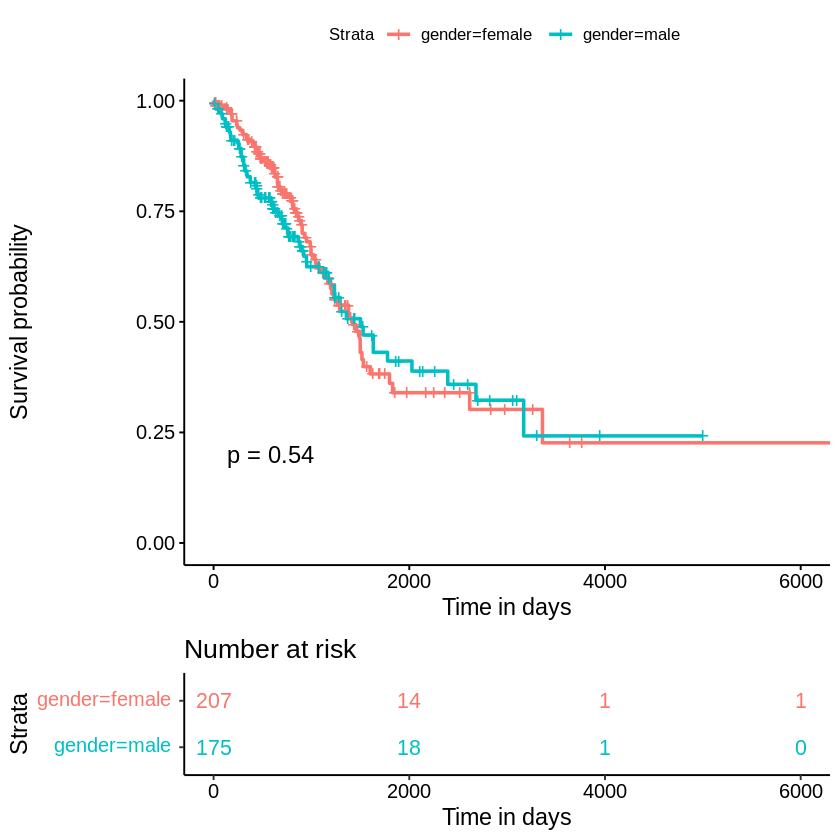

In [44]:
# we produce a Kaplan Meier plot
ggsurvplot(fit, data=input_data_tr1, pval=TRUE, risk.table=TRUE, xlab="Time in days", risk.table.col="strata")

**Survival model based on Age group**

Here, we are creating two group old >65 and young < 65 years, since mean age is 65

In [45]:
#remove samples with no age information
input_data_tr3<-subset(input_data_tr1, age_at_index!="NA")

# Create age groups based of mean age (which is nearly 65)
age = as.data.frame(ifelse(input_data_tr3$age_at_index >= mean(as.numeric(input_data_tr3$age_at_index)), "Old", "Young"))
colnames(age) <- c("Age_Group")

#Add age group column to data
input_data_tr3 <- cbind(age,input_data_tr3)

head(input_data_tr3 )

,Age_Group,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,⋯,ENSG00000152495.9,ENSG00000244464.1,ENSG00000237734.1,ENSG00000249899.4,ENSG00000277548.1,ENSG00000271716.1,ENSG00000226989.1,ENSG00000259463.1,ENSG00000267234.1,ENSG00000182376.2
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4249-01A,Old,TCGA-05-4249,Cancer,67,NA,male,NA,Alive,1523,NA,⋯,-0.825,-0.160,-0.122,0.063,-0.435,-0.167,-0.293,-0.195,-0.336,-0.245
TCGA-05-4382-01A,Old,TCGA-05-4382,Cancer,68,NA,male,NA,Alive,607,NA,⋯,-0.697,-0.160,-0.208,-0.179,-0.428,-0.198,-0.293,-0.195,-0.226,-0.337
TCGA-05-4389-01A,Old,TCGA-05-4389,Cancer,70,NA,male,NA,Alive,1369,NA,⋯,0.039,-0.160,-0.208,-0.376,-0.838,-0.165,-0.122,-0.195,-0.336,-0.422
TCGA-05-4390-01A,Young,TCGA-05-4390,Cancer,58,NA,female,NA,Alive,1126,NA,⋯,-1.072,-0.160,-0.208,-0.376,-0.941,-0.278,-0.293,-0.195,-0.040,-0.422
TCGA-05-4420-01A,Young,TCGA-05-4420,Cancer,41,NA,male,NA,Alive,912,NA,⋯,-0.952,-0.160,-0.208,-0.044,-0.762,-0.278,-0.293,-0.195,-0.336,-0.422
TCGA-05-4426-01A,Old,TCGA-05-4426,Cancer,71,NA,male,NA,Alive,791,NA,⋯,-0.827,-0.160,-0.143,0.081,-0.085,-0.034,-0.293,-0.195,-0.336,-0.378


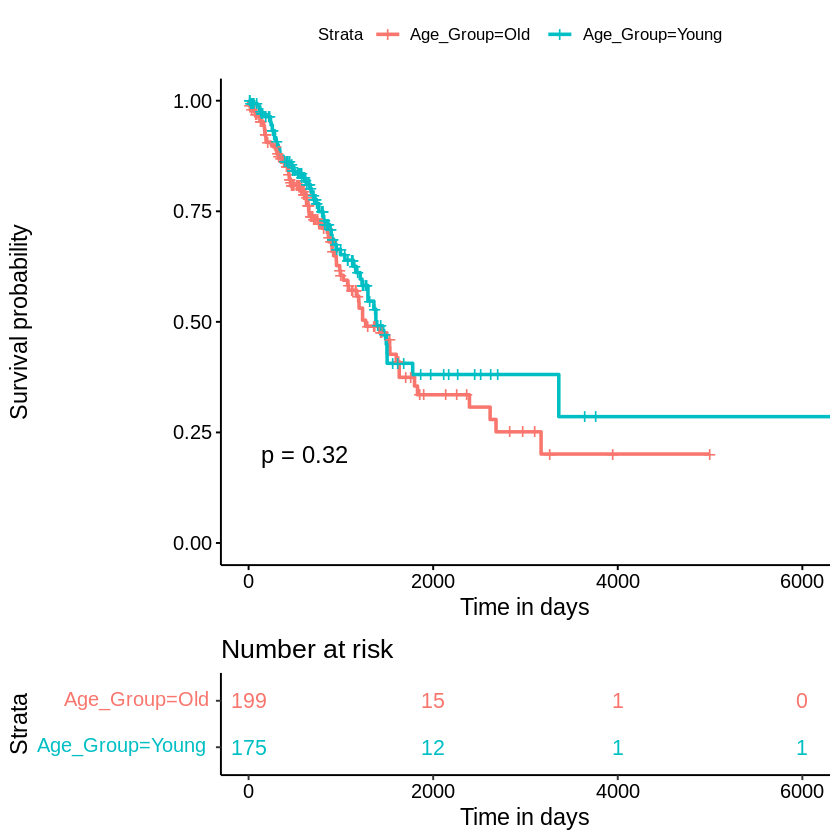

In [46]:
#Create survival object
surv_object_a <- Surv(time = as.numeric(input_data_tr3$vital.time), event = input_data_tr3$OS)

#fit model
fit_a = survfit(surv_object_a ~ Age_Group, data=input_data_tr3)

# Kaplan Meier plot
ggsurvplot(fit_a, data=input_data_tr3, pval=TRUE, risk.table=TRUE, xlab="Time in days", risk.table.col="strata")

**Develop survival model for tumor stage**

In [47]:
#survival object
surv_object <- Surv(time = as.numeric(input_data_tr1$vital.time), event = input_data_tr1$OS)

# stage based
fit_s = survfit(surv_object ~ stage, data=input_data_tr1)

cox_s <-coxph(surv_object ~ stage, data=input_data_tr1)

Create kaplan-meier plot to visualize the startifcation of risk groups

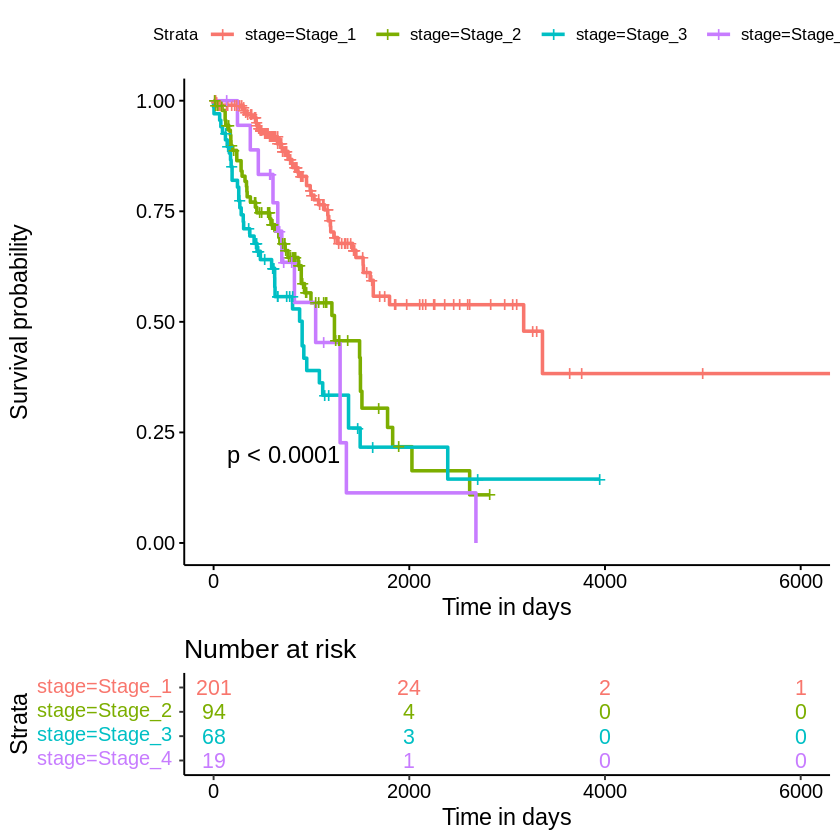

In [48]:
# we produce a Kaplan Meier plot
ggsurvplot(fit_s, data=input_data_tr1, pval=TRUE, risk.table=TRUE, xlab="Time in days", risk.table.col="stage")

**Devevlop model for smoking data**

In [49]:
#remove samples where cigarettes information is missing
input_data_tr2<-subset(input_data_tr1,cigarettes_per_day!="NA")

# Create age groups based of mean age (which is nearly 65)
smoking = as.data.frame(ifelse(input_data_tr2$cigarettes_per_day >= mean(as.numeric(input_data_tr2$cigarettes_per_day)), "High", "Low"))
colnames(smoking) <- c("smoking")

#Add age group column to data
input_data_tr2 <- cbind(smoking,input_data_tr2)

head(input_data_tr2,5)

,smoking,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,⋯,ENSG00000152495.9,ENSG00000244464.1,ENSG00000237734.1,ENSG00000249899.4,ENSG00000277548.1,ENSG00000271716.1,ENSG00000226989.1,ENSG00000259463.1,ENSG00000267234.1,ENSG00000182376.2
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4249-01A,High,TCGA-05-4249,Cancer,67,NA,male,NA,Alive,1523,NA,⋯,-0.825,-0.160,-0.122,0.063,-0.435,-0.167,-0.293,-0.195,-0.336,-0.245
TCGA-05-4382-01A,High,TCGA-05-4382,Cancer,68,NA,male,NA,Alive,607,NA,⋯,-0.697,-0.160,-0.208,-0.179,-0.428,-0.198,-0.293,-0.195,-0.226,-0.337
TCGA-05-4389-01A,High,TCGA-05-4389,Cancer,70,NA,male,NA,Alive,1369,NA,⋯,0.039,-0.160,-0.208,-0.376,-0.838,-0.165,-0.122,-0.195,-0.336,-0.422
TCGA-05-4390-01A,Low,TCGA-05-4390,Cancer,58,NA,female,NA,Alive,1126,NA,⋯,-1.072,-0.160,-0.208,-0.376,-0.941,-0.278,-0.293,-0.195,-0.040,-0.422
TCGA-05-4420-01A,Low,TCGA-05-4420,Cancer,41,NA,male,NA,Alive,912,NA,⋯,-0.952,-0.160,-0.208,-0.044,-0.762,-0.278,-0.293,-0.195,-0.336,-0.422


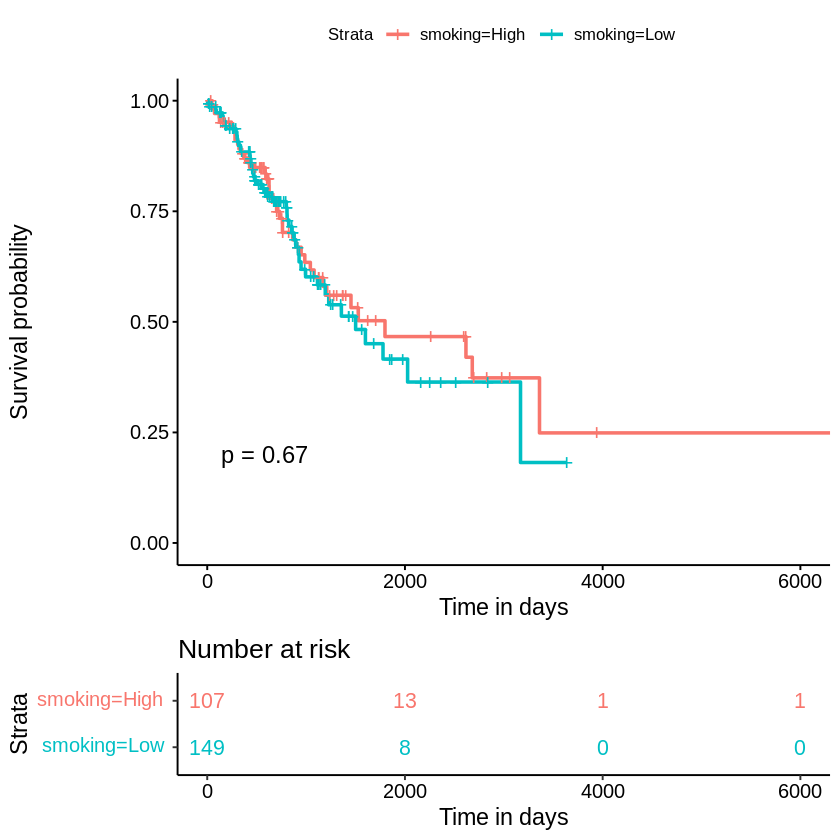

In [50]:
#Create survival object
surv_object_sm <- Surv(time = as.numeric(input_data_tr2$vital.time), event = input_data_tr2$OS)

#fit model
fit_sm = survfit(surv_object_sm ~ smoking, data=input_data_tr2)

# Kaplan Meier plot
ggsurvplot(fit_sm, data=input_data_tr2, pval=TRUE, risk.table=TRUE, xlab="Time in days", risk.table.col="strata")

From  the Univariate survival analysis based on few Clinical factors, it has been observed tumor stage is key prognostic factor for LUAD patients with p-value < 0.01.

Gender, age group and smoking (cigeretes) factors are not significant prognostic factors.

Thus, next we need to find molecular signature as prognostic factors

**Survival analysis for Molecular features**

Here, we will perform univariate survival analysis for selected transcriptomics features.

We will perform univariate survival analysis on each feature in the data employing `for` loop using COXPH model

Here, I am also applying (log rank test)  p-value (< 0.05) filetr criteria to filter only significant genes, eventually we are writing results into a file


In [51]:
# create a file to store results
write.table(cbind("Gene","Beta","HR","P-value","GP1","GP2","Hr-Inv-lst","Concordance","Std_Error"),
            file="OS-final-HRmedian-quantright.csv",row.names=F,col.names=F,sep = ',');

#Here features to compute survival start from 17th column onwards, which is transcriptomics features

for(i in seq(from=17, to=length(input_data_tr1), by=1))
{
  surv_object2 <- Surv(time = input_data_tr1$vital.time, event = input_data_tr1$OS)
  
#survival analysis: fits cox ph model to find HR for median cut
  fit1 <- survfit(surv_object2 ~ (input_data_tr1[,i])>(median(input_data_tr1[1,i])), data=input_data_tr1);
  summary(fit1);
  fit1.coxph <- coxph(surv_object2 ~ (input_data_tr1[,i])>(median(input_data_tr1[1,i])), data = input_data_tr1)
# summary(fit1.coxph);
  first <- coef(summary(fit1.coxph))
  
#check whether the pvalue is significant (< 0.05) or not
  if((first[5]<=0.05)&&(!is.na(first[5]))&&(!is.na(first[2])))
  {write.table(cbind(colnames(input_data_tr1[i]),first[1],first[2],first[5],fit1$n[1],fit1$n[2],1/first[2],fit1.coxph$concordance[6],fit1.coxph$concordance[7]),
               file="OS-final-HRmedian-quantright.csv",row.names=F,col.names=F,sep = ',',append = T);#output file
  }
}

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, c

Now, let's see the univariate survival analysis results based on molecular/transcriptomics features.

In [52]:
Surv_res <- read.table("OS-final-HRmedian-quantright.csv", sep=",", header=TRUE, row.names=1)
dim(Surv_res)
head(Surv_res)

[1] 56  8

,Beta,HR,P.value,GP1,GP2,Hr.Inv.lst,Concordance,Std_Error
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000273797.1,0.6230904,1.864682,0.0025351948,328,54,0.5362845,0.5564985,0.02026279
ENSG00000269806.1,0.5763657,1.779559,0.0007110813,199,183,0.5619369,0.5698743,0.02352446
ENSG00000253953.2,0.3787163,1.460409,0.0399832945,289,93,0.6847399,0.5300052,0.02119552
ENSG00000223653.4,0.4087640,1.504956,0.0225879892,140,242,0.6644710,0.5508693,0.02179521
ENSG00000259915.2,0.4741341,1.606622,0.0375894113,336,46,0.6224238,0.5179033,0.01598069
ENSG00000261226.1,0.4536065,1.573979,0.0274864015,115,267,0.6353327,0.5378551,0.02074515


In [53]:
# Sort features based on Corcordance
CI_features <- as.data.frame(Surv_res[order(Surv_res[,"Concordance"], decreasing =  TRUE),])
dim(CI_features)
head(CI_features)

[1] 56  8

,Beta,HR,P.value,GP1,GP2,Hr.Inv.lst,Concordance,Std_Error
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000270806.1,0.5036575,1.654763,2.954669e-03,195,187,0.6043163,0.5869169,0.02285677
ENSG00000226533.1,0.8045472,2.235684,1.111443e-04,129,253,0.4472904,0.5862111,0.01947493
ENSG00000256069.6,0.6824047,1.978630,4.900799e-05,234,148,0.5054002,0.5793252,0.02367870
ENSG00000250878.3,0.5208832,1.683514,1.971607e-03,254,128,0.5939957,0.5775521,0.02364762
ENSG00000224727.1,0.5313684,1.701259,1.533004e-03,231,151,0.5878001,0.5708556,0.02376146
ENSG00000269806.1,0.5763657,1.779559,7.110813e-04,199,183,0.5619369,0.5698743,0.02352446


56 genes found to be significant (p-value < 0.05) prognostic factors based on univariate survival analysis. Top 6 genes based on the Concordance index reprsented in the above table.

**Analyze Prognostic factors**

From the univariate analysis, 56 genes, and tumor stage found to be significant prognostic factor. Next, it would be intersting to understand whether are good or bad prognostic factor.
We can also apply more stringent criterias (HR (**Hazard ratio, Concordance Index**) to further filter or reduce signatures. 

Here, I am applying HR criteria to reduce  and understand the impact on prognosis. I will assign gene as bad prognostic factor (HR >1.2) and good prognostic factor Inverse_of_HR >1.2




In [54]:
#Bad Prognostic features based on HR >1.2
sig_surv_features <- CI_features[CI_features$Concordance >= 0.55, ]
dim(sig_surv_features)

survival_unfavorable <- sig_surv_features[sig_surv_features$HR >= 1.2, ]

dim(survival_unfavorable)
head(survival_unfavorable)

[1] 23  8

[1] 23  8

,Beta,HR,P.value,GP1,GP2,Hr.Inv.lst,Concordance,Std_Error
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000270806.1,0.5036575,1.654763,2.954669e-03,195,187,0.6043163,0.5869169,0.02285677
ENSG00000226533.1,0.8045472,2.235684,1.111443e-04,129,253,0.4472904,0.5862111,0.01947493
ENSG00000256069.6,0.6824047,1.978630,4.900799e-05,234,148,0.5054002,0.5793252,0.02367870
ENSG00000250878.3,0.5208832,1.683514,1.971607e-03,254,128,0.5939957,0.5775521,0.02364762
ENSG00000224727.1,0.5313684,1.701259,1.533004e-03,231,151,0.5878001,0.5708556,0.02376146
ENSG00000269806.1,0.5763657,1.779559,7.110813e-04,199,183,0.5619369,0.5698743,0.02352446


In [55]:
#Good Prognostic features based on inverse of HR >1.2
survival_favorable <- sig_surv_features[sig_surv_features$Hr.Inv.lst >= 1.2, ]
dim(survival_favorable)
head(survival_favorable)

[1] 0 8

Beta,HR,P.value,GP1,GP2,Hr.Inv.lst,Concordance,Std_Error
<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>


After applying filter criteria, we found 23 genes as significant bad prognostic factors and none of genes able to pass filter criteria for good prognostic factor

**Gene Annotation**

After identifying significant prognostic genes. It is also important we must be able annotate to undrstand what are these transcripts . Here, I am using `org.Hs.eg.db` package to annotate our genes. We can also perform annotatation using other databases as well.

In [56]:
#install package
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("org.Hs.eg.db")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'org.Hs.eg.db'

also installing the dependencies ‘zlibbioc’, ‘GenomeInfoDbData’, ‘XVector’, ‘GenomeInfoDb’, ‘plogr’, ‘Biostrings’, ‘BiocGenerics’, ‘Biobase’, ‘IRanges’, ‘RSQLite’, ‘S4Vectors’, ‘KEGGREST’, ‘AnnotationDbi’


Old packages: 'gert', 'htmltools', 'knitr', 'openssl', 'pkgload', 'rmarkdown',
  'roxygen2', 'stringi', 'tibble', 'vroom', 'waldo', 'xfun', 'nlme'



In [ ]:
library(org.Hs.eg.db)
keytypes(org.Hs.eg.db)

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, uniqu

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MAP"         
[16] "OMIM"         "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"        
[21] "PMID"         "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"      
[26] "UNIPROT"

In [ ]:
#check names of columns that we have in database
columns(org.Hs.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MAP"         
[16] "OMIM"         "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"        
[21] "PMID"         "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"      
[26] "UNIPROT"

In [ ]:
#column we want to extract
#cols <- c("SYMBOL", "ENTREZID", "GENETYPE", "GOALL", "ONTOLOGY", "PATH")

cols <- c("SYMBOL", "ENTREZID", "GENETYPE", "GENENAME")

In [ ]:
#get all important features as characters
CI_f<- as.character(row.names(CI_features))

# convert ensemble transcript IDs to ensemble IDs (since, above database have information regarding only ensemble)
CI_f1 <- gsub("\\.[0-9]*$", "", CI_f)


In [ ]:
# Perform annotation
annotated_genes <- as.data.frame(select(org.Hs.eg.db, keys=CI_f1, columns=cols, keytype="ENSEMBL"))
head(annotated_genes, 20)

'select()' returned 1:1 mapping between keys and columns



,ENSEMBL,SYMBOL,ENTREZID,GENETYPE,GENENAME
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000270806,C17orf50,146853,protein-coding,chromosome 17 open reading frame 50
2,ENSG00000226533,BTBD9-AS1,101929425,ncRNA,BTBD9 antisense RNA 1
3,ENSG00000256069,A2MP1,3,pseudo,alpha-2-macroglobulin pseudogene 1
4,ENSG00000250878,METTL21EP,121952,pseudo,"methyltransferase like 21E, pseudogene"
5,ENSG00000224727,NA,NA,NA,NA
6,ENSG00000269806,NA,NA,NA,NA
7,ENSG00000278909,NA,NA,NA,NA
8,ENSG00000242307,NA,NA,NA,NA
9,ENSG00000235033,DAAM2-AS1,100505635,ncRNA,DAAM2 antisense RNA 1


**Draw KM plot for a specific gene**

In [ ]:
#Extract gene expression data for that gene
gene1 <- input_data_tr1$ENSG00000226533.1

#extract survival  information
os <- input_data_tr1$OS
os.time <- input_data_tr1$vital.time

# create a new column regulation status for the gene based on the cut of median value
reg_status = as.data.frame(ifelse(input_data_tr1$ENSG00000226533.1 >= median(as.numeric(input_data_tr1$ENSG00000226533.1)), "Upreg", "Down_reg"))

# add column name
colnames(reg_status) <- c("Reg_status")

#combine information together to create a new data frame
gene1_data <- cbind(gene1,os, os.time, reg_status)

#print top rows
head(gene1_data)

,gene1,os,os.time,Reg_status
,<chr>,<dbl>,<int>,<chr>
1,-0.138,0,1523,Down_reg
2,-0.269,0,607,Upreg
3,-0.251,0,1369,Upreg
4,-0.087,0,1126,Down_reg
5,-0.267,0,912,Upreg
6,-0.312,0,791,Upreg


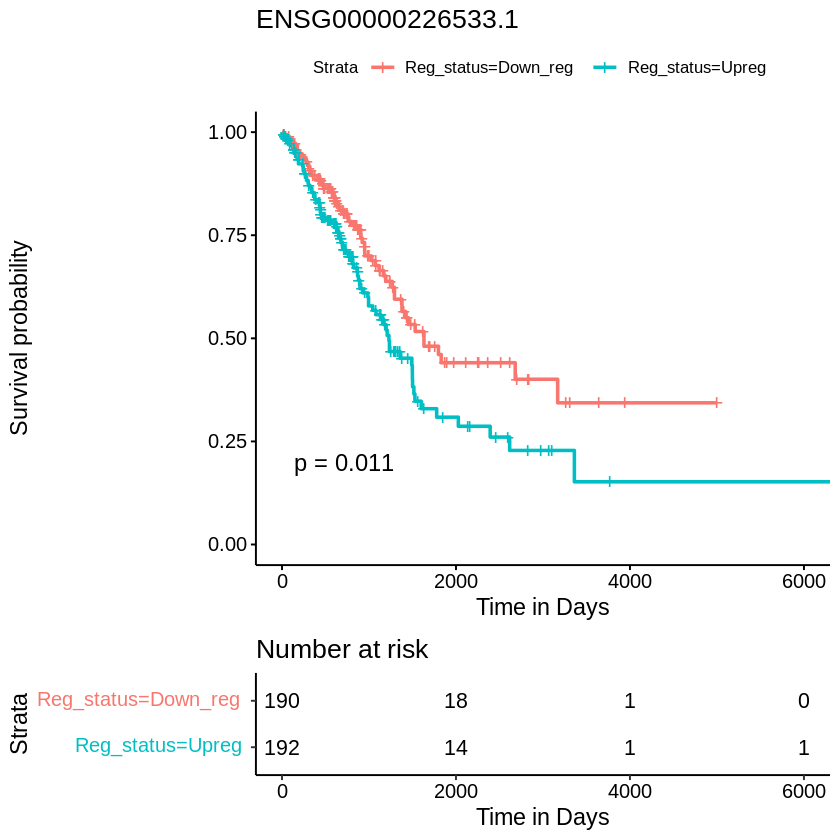

In [ ]:
#create survival object
surv_object2 <- Surv(time = gene1_data$os.time, event = gene1_data$os)

#fit model  
fit_G <- survfit(surv_object2 ~ Reg_status , data=gene1_data)

#Draw KM plot
ggsurvplot(fit_G, data=gene1_data, pval=TRUE, xlab="Time in Days", risk.table=TRUE, title="ENSG00000226533.1")

**Multivariate Prognostic models**

From the univariate analysis, we are able to identify 23 genes and stage as significant prognostic factors.

To understand whether these genes (top 6) and clinical factors also act as independent prognostic factor. We need to develop multivariate survival analysis.

Manipulate genes Ids (replace digits after decimals with none, since, code is not able to take it's original name as numeric factor)

In [57]:
nm <- names(input_data_tr1)
nm2 <- gsub("\\.[0-9]*$", "", nm)

# Recreate data with substituted column names
ip <- input_data_tr1
colnames(ip) <- nm2

#Print top rows
head(ip [16:20],5)

,class,ENSG00000259883,ENSG00000231981,ENSG00000263089,ENSG00000233540
,<dbl>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4249-01A,1,-0.068,-0.121,-0.085,1.450
TCGA-05-4382-01A,1,-0.353,-0.157,-0.468,0.129
TCGA-05-4389-01A,1,-0.362,-0.250,-0.491,-0.040
TCGA-05-4390-01A,1,-0.367,-0.250,-0.472,-0.455
TCGA-05-4420-01A,1,-0.234,-0.250,-0.320,-0.455


In [ ]:
head(survival_unfavorable)

,Beta,HR,P.value,GP1,GP2,Hr.Inv.lst,Concordance,Std_Error
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000270806.1,0.5036575,1.654763,2.954669e-03,195,187,0.6043163,0.5869169,0.02285677
ENSG00000226533.1,0.8045472,2.235684,1.111443e-04,129,253,0.4472904,0.5862111,0.01947493
ENSG00000256069.6,0.6824047,1.978630,4.900799e-05,234,148,0.5054002,0.5793252,0.02367870
ENSG00000250878.3,0.5208832,1.683514,1.971607e-03,254,128,0.5939957,0.5775521,0.02364762
ENSG00000224727.1,0.5313684,1.701259,1.533004e-03,231,151,0.5878001,0.5708556,0.02376146
ENSG00000269806.1,0.5763657,1.779559,7.110813e-04,199,183,0.5619369,0.5698743,0.02352446


**Multivariate model**

First develop multivariate model with clinical factor and top molecular features (based on CI value)

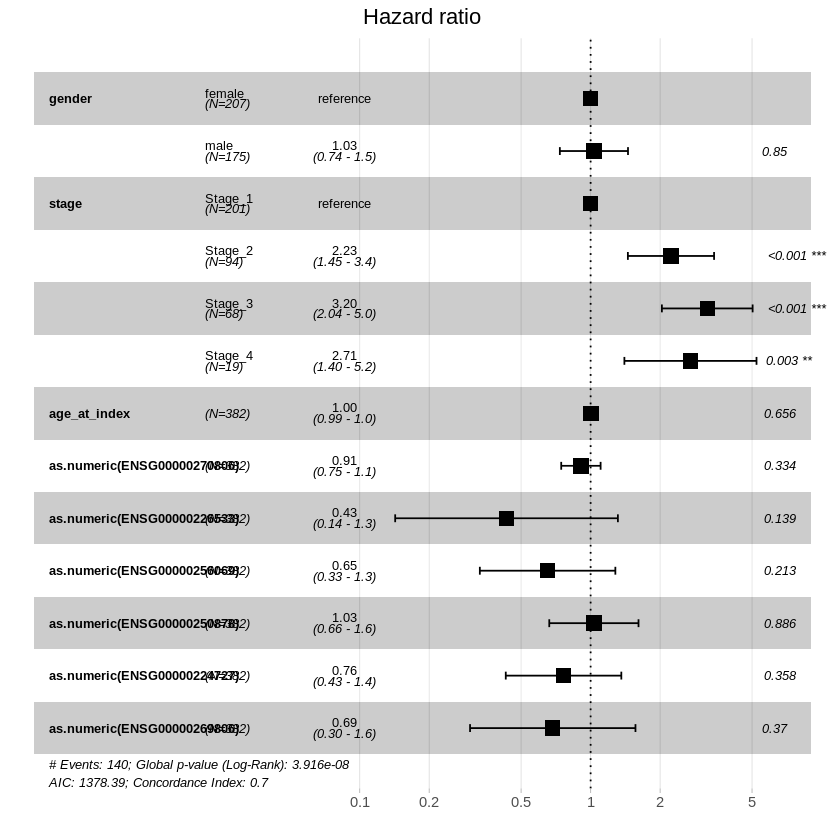

In [58]:
# Fit a Cox proportional hazards model
surv_object_n <- Surv(time = ip$vital.time, event = ip$OS)
fit.coxph <- coxph(surv_object_n ~   gender + stage + age_at_index + as.numeric(ENSG00000270806) + as.numeric(ENSG00000226533) + as.numeric(ENSG00000256069) + as.numeric(ENSG00000250878) + as.numeric(ENSG00000224727)+ as.numeric(ENSG00000269806) , data = ip )
ggforest(fit.coxph, data = ip)

From the multivariate analysis, we observed tumor stage is only significant prognostic factor, while none of the top 6 genes independently acts as significant prognostic factor.

Thus, we need to design better prognostic molecular signature. One approach is that we can develop PI (prognostic Index model), where we can combine multiple genes (considering their Coefficients values in univariate analysis)

`Coeff of gene1 * expression of Gene1 + Coeff of gene2 * expression of Gene2 + ... + Coeff of geneN * expression of GeneN`

Here, I am using same top six genes to build PI model

In [ ]:
head(survival_unfavorable)

,Beta,HR,P.value,GP1,GP2,Hr.Inv.lst,Concordance,Std_Error
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000270806.1,0.5036575,1.654763,2.954669e-03,195,187,0.6043163,0.5869169,0.02285677
ENSG00000226533.1,0.8045472,2.235684,1.111443e-04,129,253,0.4472904,0.5862111,0.01947493
ENSG00000256069.6,0.6824047,1.978630,4.900799e-05,234,148,0.5054002,0.5793252,0.02367870
ENSG00000250878.3,0.5208832,1.683514,1.971607e-03,254,128,0.5939957,0.5775521,0.02364762
ENSG00000224727.1,0.5313684,1.701259,1.533004e-03,231,151,0.5878001,0.5708556,0.02376146
ENSG00000269806.1,0.5763657,1.779559,7.110813e-04,199,183,0.5619369,0.5698743,0.02352446


**Prognostic Index (PI)  model with top 6 genes**

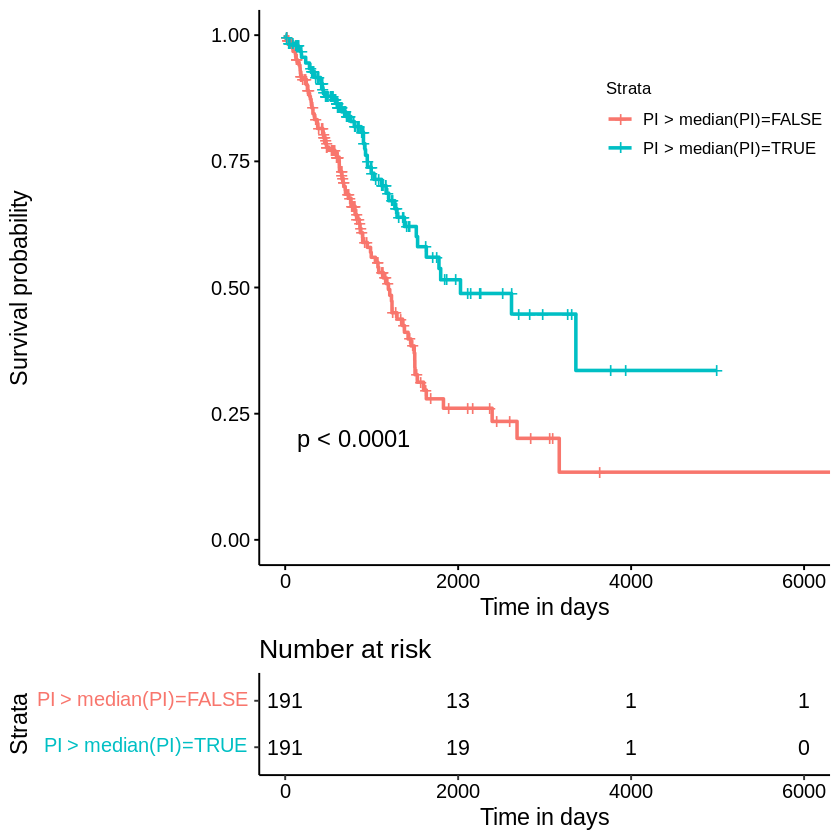

In [ ]:
PI=0

PI= PI + as.numeric(ip$ENSG00000270806)*0.504 + as.numeric(ip$ENSG00000226533)*0.805 + as.numeric(ip$ENSG00000256069)*0.682 + as.numeric(ip$ENSG00000250878)*0.521 + as.numeric(ip$ENSG00000224727)*0.531+ as.numeric(ip$ENSG00000269806)*0.576

ip$PI<-PI

surv_object_p <- Surv(time = ip$vital.time, event = ip$OS)

fit <- survfit(surv_object_p~(ip$PI>median(ip$PI)), data=ip)
ggsurvplot(fit, pval = TRUE, censor = TRUE, conf.int = F, xlab = "Time in days",  legend=c(0.8,0.8), risk.table=TRUE) 


Multivariate model with PI model

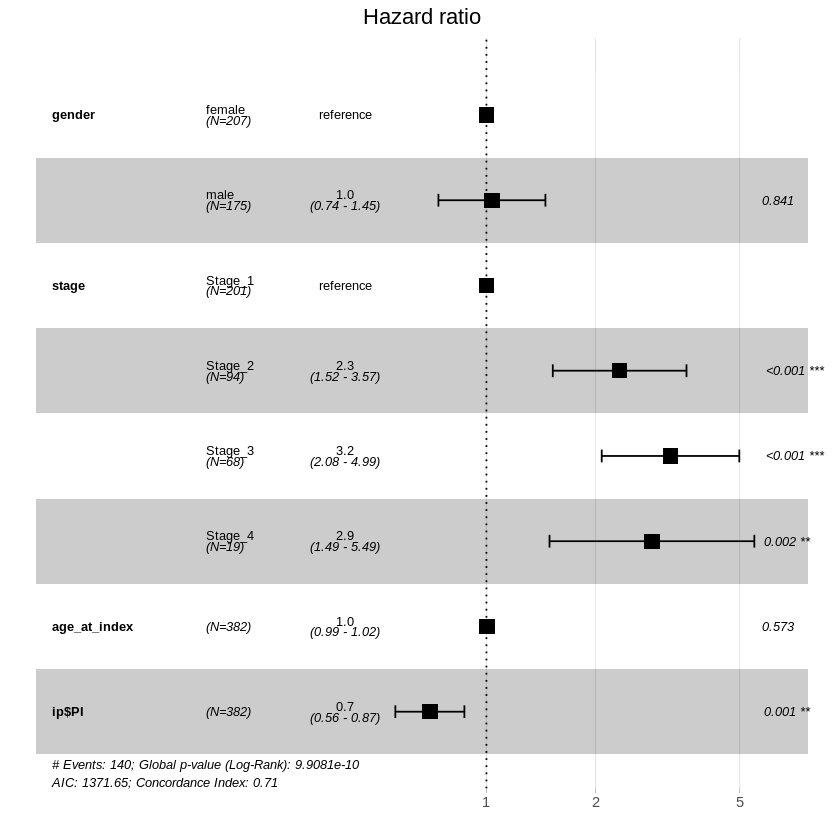

In [ ]:
# Fit a Cox proportional hazards model
surv_object_n <- Surv(time = ip$vital.time, event = ip$OS)
fit.coxph <- coxph(surv_object_n ~   gender + stage + age_at_index + ip$PI, data = ip )
ggforest(fit.coxph, data = ip)

PI model acts as significant prognostic factor both as univariate and multivariate models

Note: we can develop PI models with different combinations of features to obtain best model for publication purpose

**Model Evaluation on test data**

For final validation, we must be validate our prognostic models on an independent dataset, which was not used during the feature selection and training or development of the model.

Here, I am using 20% data from the full data as test data

Prepare test data for survival analysis

In [59]:
#remove samples where OS.time is NA
input_data_te1<-subset(sel_te,vital.time!="NA")

#Check dimensions of data
dim(input_data_te1)

[1] 100 610

In [ ]:
names1 <- names(input_data_te1)
names2 <- gsub("\\.[0-9]*$", "", names1)

te_ip <- input_data_te1
colnames(te_ip) <- names2

dim(te_ip)
head(te_ip, 5)

[1] 100 610

,id3,tissue_type,age_at_index,ethnicity,gender,race,vital_status,vital.time,days_to_death,days_to_last_follow_up,⋯,ENSG00000152495,ENSG00000244464,ENSG00000237734,ENSG00000249899,ENSG00000277548,ENSG00000271716,ENSG00000226989,ENSG00000259463,ENSG00000267234,ENSG00000182376
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4417-01A,TCGA-05-4417,Cancer,51,NA,female,NA,Alive,455,NA,455,⋯,0.583,-0.160,0.260,-0.037,-0.193,-0.278,-0.293,0.019,-0.336,-0.309
TCGA-05-4422-01A,TCGA-05-4422,Cancer,68,NA,male,NA,Alive,365,NA,365,⋯,0.445,-0.160,-0.137,-0.226,-0.037,-0.097,-0.293,-0.195,-0.210,-0.229
TCGA-35-4122-01A,TCGA-35-4122,Cancer,69,not hispanic or latino,male,white,Alive,225,NA,225,⋯,-0.684,-0.160,-0.208,-0.376,-1.326,-0.278,-0.293,-0.058,-0.336,-0.422
TCGA-38-4625-01A,TCGA-38-4625,Cancer,66,not hispanic or latino,female,white,Alive,2973,NA,2973,⋯,-0.935,-0.100,-0.208,-0.313,-0.871,-0.203,-0.293,-0.195,-0.336,-0.342
TCGA-38-4631-01A,TCGA-38-4631,Cancer,72,not hispanic or latino,female,white,Dead,354,354,NA,⋯,-0.990,-0.160,-0.208,-0.376,-1.326,-0.278,-0.293,-0.195,-0.336,-0.422


Call: survfit(formula = surv_object1 ~ stage, data = input_data_te1)

               n events median 0.95LCL 0.95UCL
stage=Stage_1 54     14     NA    1258      NA
stage=Stage_2 25     11    995     582      NA
stage=Stage_3 16      9   1265     336      NA
stage=Stage_4  5      4    976     167      NA


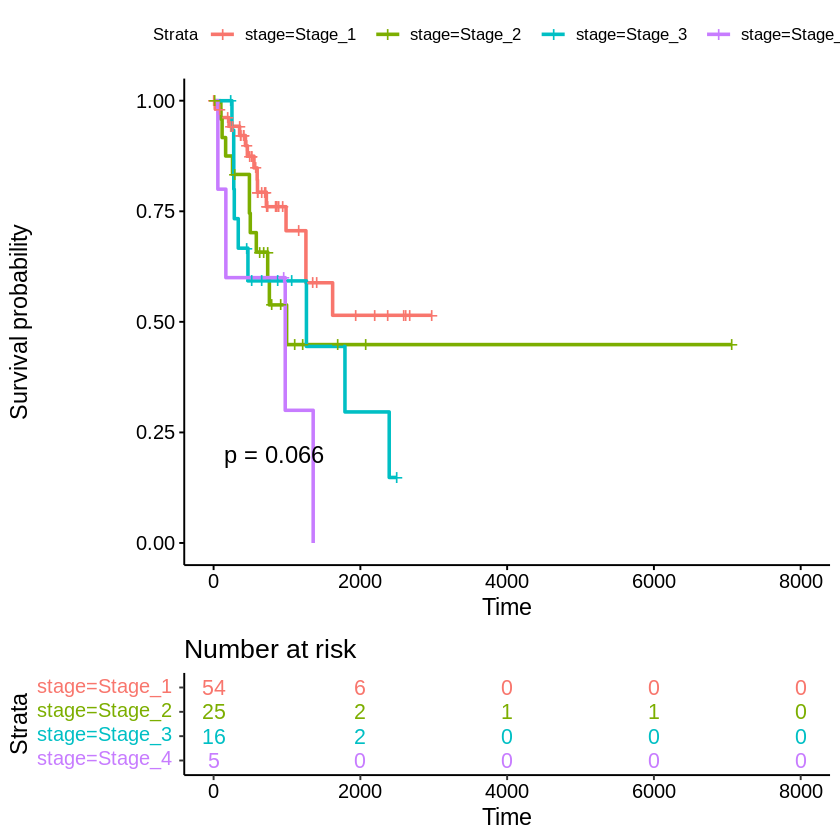

In [ ]:
# stage based
surv_object1 <- Surv(time = as.numeric(input_data_te1$vital.time), event = input_data_te1$OS)
fit_s1 = survfit(surv_object1 ~ stage, data=input_data_te1)

print(fit_s1)
# we produce a Kaplan Meier plot
ggsurvplot(fit_s1, data=input_data_te1, pval=TRUE, risk.table=TRUE, risk.table.col="stage")

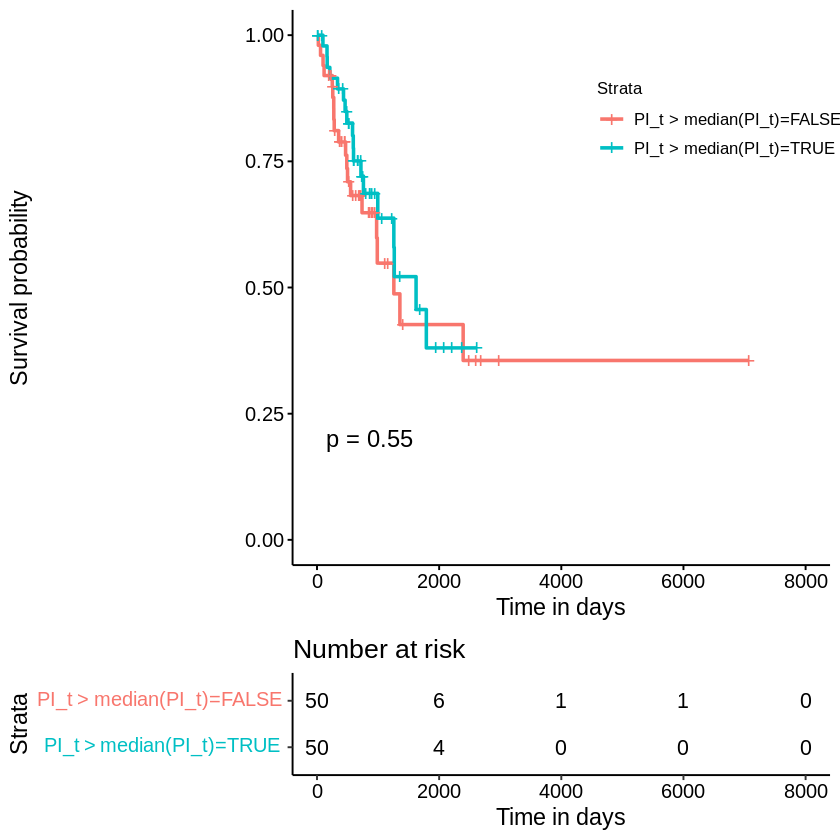

In [ ]:
#PI model
PI_t=0
PI_t= PI_t +  as.numeric(te_ip$ENSG00000270806)*0.504 + as.numeric(te_ip$ENSG00000226533)*0.805 + as.numeric(te_ip$ENSG00000256069)*0.682 + as.numeric(te_ip$ENSG00000250878)*0.521 + as.numeric(te_ip$ENSG00000224727)*0.531+ as.numeric(te_ip$ENSG00000269806)*0.576

te_ip$PI_t<-PI_t
surv_object_p_t <- Surv(time = te_ip$vital.time, event = te_ip$OS)

fit_t <- survfit(surv_object_p_t~(te_ip$PI_t>median(te_ip$PI_t)), data=te_ip)
ggsurvplot(fit_t, pval = TRUE, censor = TRUE, conf.int = F, xlab = "Time in days",  legend=c(0.8,0.8), risk.table=TRUE) 


**Multivariate model**

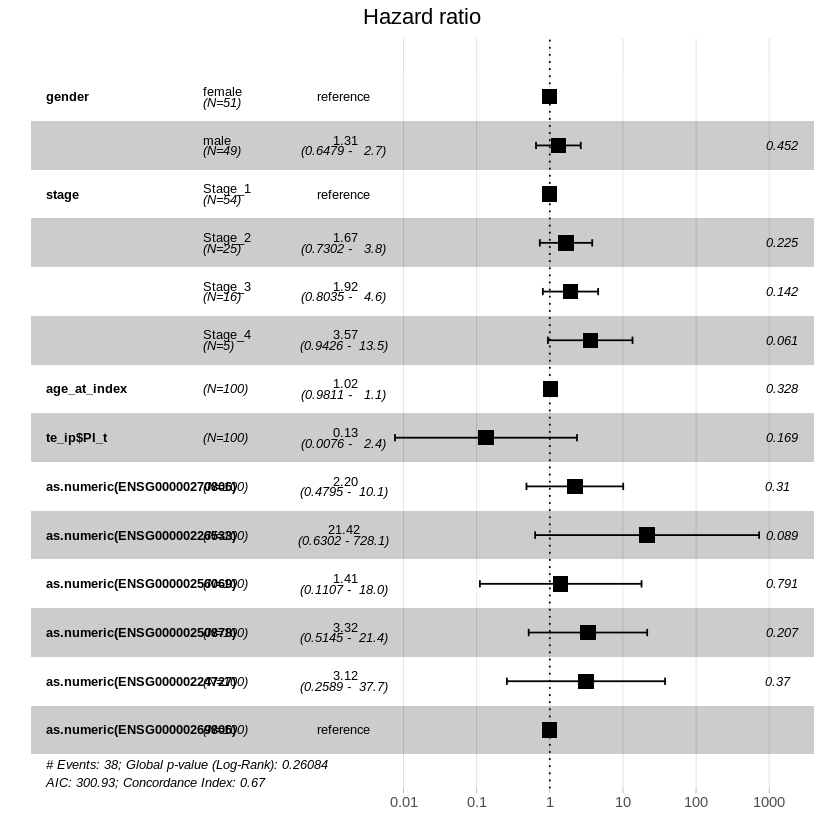

In [ ]:
# Fit a Cox proportional hazards model
surv_object_p_t <- Surv(time = te_ip$vital.time, event = te_ip$OS)
fit.coxph_t <- coxph(surv_object_p_t ~   gender + stage + age_at_index + te_ip$PI_t + as.numeric(ENSG00000270806) + as.numeric(ENSG00000226533) + as.numeric(ENSG00000256069) + as.numeric(ENSG00000250878) + as.numeric(ENSG00000224727)+ as.numeric(ENSG00000269806) , data = te_ip )
ggforest(fit.coxph_t, data = te_ip)

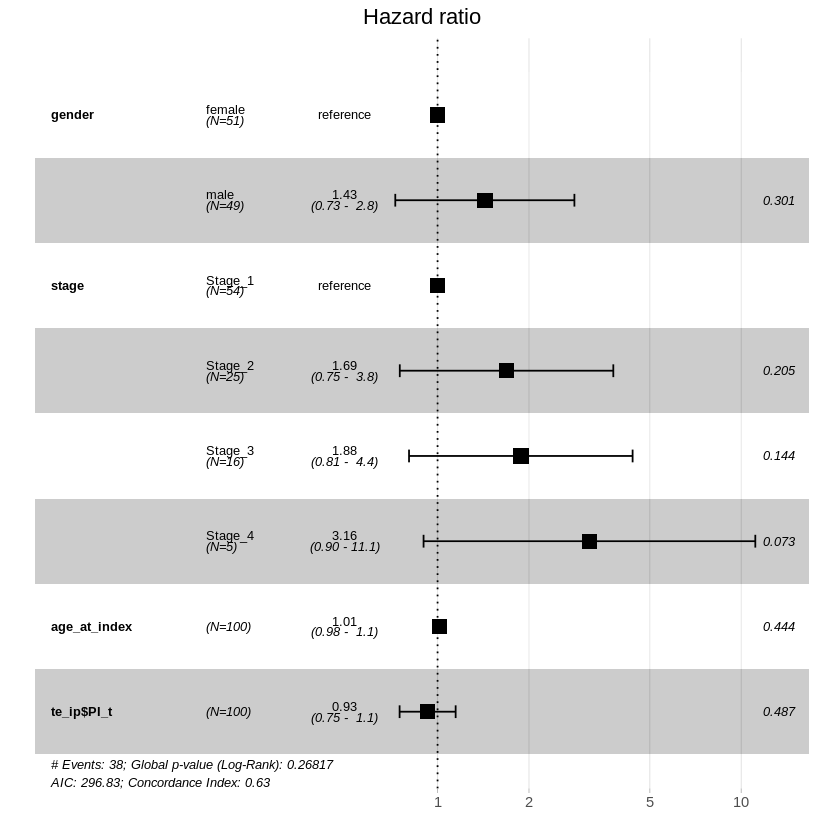

In [ ]:
# Multivariate Cox proportional hazards model
surv_object_p_t <- Surv(time = te_ip$vital.time, event = te_ip$OS)
fit.coxph_t <- coxph(surv_object_p_t ~   gender + stage + age_at_index + te_ip$PI_t, data = te_ip )
ggforest(fit.coxph_t, data = te_ip)

Our model is not validated on test data based on this combination of features.

**Note:** For the final project work purpose, We can try more combination not just these 6 genes to validate model on test data

**Classification Prediction models**

**Stage classification**

Since, survival analysis indicates stage is important prognostic factor. 
Thus, it would be interesting to identify signatures that can classify tumor stage, probably, those transcriptomics  signatures can also be employed as prognostic signature.
Besides, we can also try to identify genes that can classify early and late stage tumor samples.

Here, for excersie purpose, I am considering only 594 significant differential expressed genes (cancer vs Normal) as start input for stage classification. In Ideal condition/scenario, we should start with whole set of genes to apply filter selection techniques.

Note: We are creating binary classification models

Early stage (stage 1 and stage 2) = 1
Late stage (stage 3 and stage 4) = 0

**Create binary labels for tumor stage**


In [60]:
input_data_tr1$cl <- recode(input_data_tr1$tumor_stage,"c('stage ia','stage ib','stage i')=1;c('stage iia','stage iib','stage ii')= 1;c('stage iiia','stage iiib','stage iii')=0; c('stage iv')=0")
input_data_te1$cl <- recode(input_data_te1$tumor_stage,"c('stage ia','stage ib','stage i')=1;c('stage iia','stage iib','stage ii')= 1;c('stage iiia','stage iiib','stage iii')=0; c('stage iv')=0")

tr_class <- input_data_tr1$cl 
te_class <- input_data_te1$cl 

tr_exp1 <- input_data_tr1[17:ncol(input_data_tr1)]
te_exp1 <- input_data_te1[17:ncol(input_data_te1)]


Combine clinical data with selected exprssion data

In [61]:
new_tr <- cbind(tr_class, tr_exp1)
new_te <- cbind(te_class, te_exp1)

dim(new_tr)
dim(new_te)

head(new_tr, 5)

[1] 382 596

[1] 100 596

,tr_class,ENSG00000259883.1,ENSG00000231981.3,ENSG00000263089.1,ENSG00000233540.1,ENSG00000273797.1,ENSG00000106069.19,ENSG00000248935.1,ENSG00000236998.2,ENSG00000111783.11,⋯,ENSG00000244464.1,ENSG00000237734.1,ENSG00000249899.4,ENSG00000277548.1,ENSG00000271716.1,ENSG00000226989.1,ENSG00000259463.1,ENSG00000267234.1,ENSG00000182376.2,cl
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
TCGA-05-4249-01A,1,-0.068,-0.121,-0.085,1.450,-0.353,-0.131,-0.201,-0.271,-0.251,⋯,-0.160,-0.122,0.063,-0.435,-0.167,-0.293,-0.195,-0.336,-0.245,1
TCGA-05-4382-01A,1,-0.353,-0.157,-0.468,0.129,-0.192,-0.323,-0.201,0.050,-0.226,⋯,-0.160,-0.208,-0.179,-0.428,-0.198,-0.293,-0.195,-0.226,-0.337,1
TCGA-05-4389-01A,1,-0.362,-0.250,-0.491,-0.040,-0.288,1.927,-0.201,-0.370,-0.215,⋯,-0.160,-0.208,-0.376,-0.838,-0.165,-0.122,-0.195,-0.336,-0.422,1
TCGA-05-4390-01A,1,-0.367,-0.250,-0.472,-0.455,-0.417,-1.186,-0.201,-0.176,-0.251,⋯,-0.160,-0.208,-0.376,-0.941,-0.278,-0.293,-0.195,-0.040,-0.422,1
TCGA-05-4420-01A,1,-0.234,-0.250,-0.320,-0.455,-0.369,-1.304,-0.201,-0.296,-0.251,⋯,-0.160,-0.208,-0.044,-0.762,-0.278,-0.293,-0.195,-0.336,-0.422,1


**Feature selection with Random forest**

In [62]:
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [63]:
library("randomForest")

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin





**Select features with RF**

In [64]:
#Load libraries
numtrees <- as.numeric(500)
#new_tr1 <- as.matrix(new_tr)
rforest <- randomForest(as.factor(tr_class) ~ ., data=new_tr, ntree=numtrees, metric="Accuracy", importance=TRUE)

Model

In [65]:
rforest


Call:
 randomForest(formula = as.factor(tr_class) ~ ., data = new_tr,      ntree = numtrees, metric = "Accuracy", importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 24

        OOB estimate of  error rate: 15.97%
Confusion matrix:
   0   1 class.error
0 26  61   0.7011494
1  0 295   0.0000000

**Create an output for features by feature importance**


,MeanDecreaseAccuracy,MeanDecreaseGini
ENSG00000259883.1,2.0133307,0.2725781
ENSG00000231981.3,-1.1622368,0.1422806
ENSG00000263089.1,1.4371058,0.3637100
ENSG00000233540.1,-1.6452152,0.1344267
ENSG00000273797.1,1.6979519,0.1648332
ENSG00000106069.19,0.7318541,0.2452629


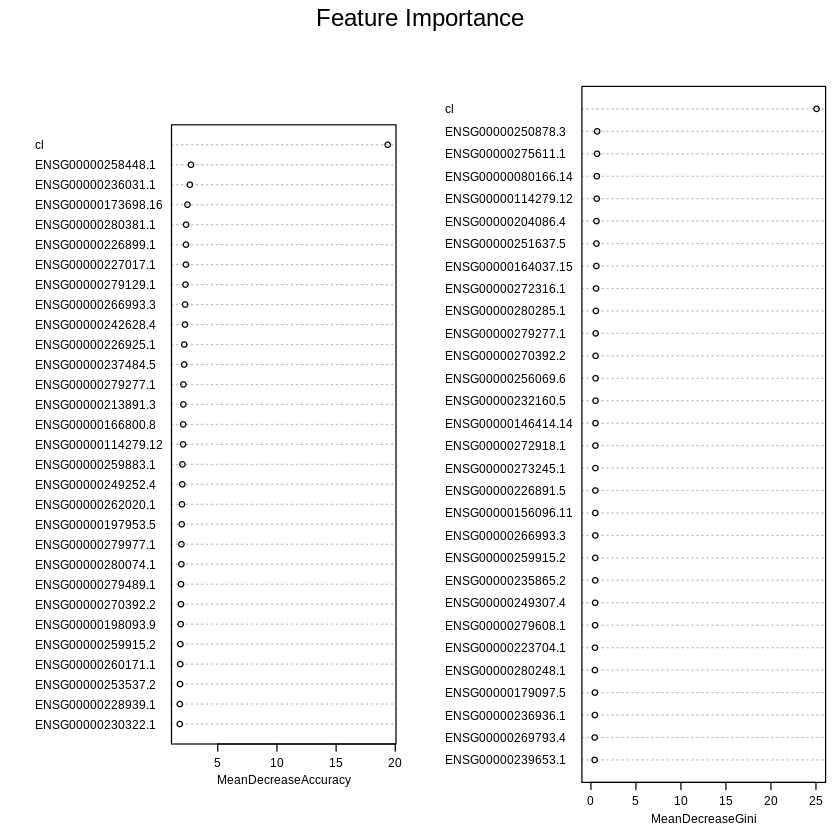

In [120]:
#Feature importance
varImpPlot(rforest, main='Feature Importance', pch=1, cex=0.6)

#Store features in a vaiable as features
rf_features <- varImpPlot(rforest, main='Feature Importance', pch=1, cex=0.6)

head(rf_features)

#Write features in a txt file format
write.table(rf_features,'RF_features_importance.txt', row.names=TRUE,col.names=NA, sep='\t', quote=FALSE)

**Sort features based on the MeanDecrease Accuracy (for classification models) or %IncMSE (for regression models)**

In [67]:
# Sort features based on meanDecreaseAccuracy value
sorted_features_rf <- as.data.frame(rf_features[order(rf_features[,"MeanDecreaseAccuracy"], decreasing = TRUE),])
#sorted_features_rf <- as.data.frame(rf_features[order(rf_features[,"%IncMSE"], decreasing = TRUE),])

head(sorted_features_rf)

,MeanDecreaseAccuracy,MeanDecreaseGini
,<dbl>,<dbl>
cl,19.356490,25.0683395
ENSG00000258448.1,2.736588,0.3169987
ENSG00000236031.1,2.640009,0.3484062
ENSG00000173698.16,2.438146,0.2300386
ENSG00000280381.1,2.326359,0.1640839
ENSG00000226899.1,2.315499,0.2700226


Select top features based on MeandecreaseAccuracy score. Higher mean decrease accuracy score, more important feature would be classification model.

Note: Here, I am using filetr crietria >= 1.5. This filter criteria can be varied for selecting different subsets of features.

In [121]:
#select only top features (meanDecreaseaccuracy or %IncMSE >1.5)
top_features_rf <- sorted_features_rf[sorted_features_rf$MeanDecreaseAccuracy>1.2, ]
#top_features_rf <- sorted_features_rf[sorted_features_rf[1]>1.5, ]
dim(top_features_rf)
head(top_features_rf)

[1] 85  2

,MeanDecreaseAccuracy,MeanDecreaseGini
,<dbl>,<dbl>
cl,19.356490,25.0683395
ENSG00000258448.1,2.736588,0.3169987
ENSG00000236031.1,2.640009,0.3484062
ENSG00000173698.16,2.438146,0.2300386
ENSG00000280381.1,2.326359,0.1640839
ENSG00000226899.1,2.315499,0.2700226


Create dataframe of top features only


In [122]:
#create data frame for features only
top_rf <- as.data.frame(row.names(top_features_rf))

#add class column as well
#top1<-rbind(c("class"), top1)
 
#add column names
colnames(top_rf) <- c("ID")

#Write into a file
write.table(top_rf,'top_rf_features_list.txt', row.names=F,  sep='\t', quote=FALSE)

Prepare training and test data with selected features

In [123]:
# Prepare training data with only selected top features
input_data_tr1_t <- t(input_data_tr1)
input_data_te1_t <- t(input_data_te1)

#Prepare test data with selected features
tr_selected_data1 <- as.data.frame(input_data_tr1_t[row.names(input_data_tr1_t) %in% c(top_rf$ID), ])

#Prepare test data with selected features
te_selected_data1 <- as.data.frame(input_data_te1_t[row.names(input_data_te1_t) %in% c(top_rf$ID), ])

#Check dimensions of dataset
dim(tr_selected_data1)
dim(te_selected_data1)

[1]  85 382

[1]  85 100

In [124]:
#transpose train and test data
tr1 <-t(tr_selected_data1)
te1 <-t(te_selected_data1)

tr_class <- as.data.frame(new_tr$cl)
te_class <- as.data.frame(new_te$cl )

colnames(tr_class)<- c("class")
colnames(te_class)<- c("class")

# combine clinical data with gene expression for selected train & Test data
final_sel_tr_c <- cbind(tr_class, tr1)
final_sel_te_c <- cbind(te_class, te1)


write.table(final_sel_tr_c,'tr_rf_selected_data1.txt', row.names=F,  sep='\t', quote=FALSE)
write.table(final_sel_tr_c,'te_rf_selected_data1.txt', row.names=F,  sep='\t', quote=FALSE)


#Check dimensions
dim(final_sel_tr_c)
dim(final_sel_te_c)

head(final_sel_tr_c,3)
head(final_sel_te_c,3)

[1] 382  86

[1] 100  86

,class,ENSG00000259883.1,ENSG00000263089.1,ENSG00000273797.1,ENSG00000223882.1,ENSG00000185774.13,ENSG00000280381.1,ENSG00000271917.1,ENSG00000259915.2,ENSG00000197953.5,⋯,ENSG00000241101.1,ENSG00000280219.1,ENSG00000230322.1,ENSG00000235865.2,ENSG00000279129.1,ENSG00000237773.4,ENSG00000223704.1,ENSG00000170160.15,ENSG00000152495.9,cl
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4249-01A,1,-0.068,-0.085,-0.353,-0.167,-0.619,-0.137,-0.168,-0.371,-0.208,⋯,-0.015,-0.380,-0.212,-0.063,-0.171,-0.293,0.463,-0.472,-0.825,1
TCGA-05-4382-01A,1,-0.353,-0.468,-0.192,-0.243,-0.153,-0.261,-0.168,-0.286,-0.185,⋯,-0.172,-0.317,-0.212,-0.154,-0.234,-0.399,-0.176,0.206,-0.697,1
TCGA-05-4389-01A,1,-0.362,-0.491,-0.288,-0.443,-0.259,-0.201,-0.168,-0.401,0.913,⋯,-0.263,0.073,-0.212,-0.283,-0.219,-0.387,-0.531,-0.472,0.039,1


,class,ENSG00000259883.1,ENSG00000263089.1,ENSG00000273797.1,ENSG00000223882.1,ENSG00000185774.13,ENSG00000280381.1,ENSG00000271917.1,ENSG00000259915.2,ENSG00000197953.5,⋯,ENSG00000241101.1,ENSG00000280219.1,ENSG00000230322.1,ENSG00000235865.2,ENSG00000279129.1,ENSG00000237773.4,ENSG00000223704.1,ENSG00000170160.15,ENSG00000152495.9,cl
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-05-4417-01A,1,-0.089,-0.398,-0.417,-0.443,-0.326,-0.222,-0.168,-0.288,-0.208,⋯,-0.263,0.127,-0.212,-0.403,0.186,0.652,-0.435,-0.404,0.583,1
TCGA-05-4422-01A,1,-0.267,-0.051,-0.115,-0.106,-0.147,-0.190,-0.065,0.027,-0.208,⋯,0.040,-0.527,-0.159,-0.285,-0.087,0.058,-0.036,0.121,0.445,1
TCGA-35-4122-01A,1,-0.244,-0.512,-0.265,-0.443,-0.364,-0.265,-0.168,-0.279,-0.208,⋯,-0.263,-0.436,-0.135,-0.478,-0.181,0.090,-0.560,-0.442,-0.684,1


Install required packages 

In [109]:
install.packages("e1071")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [126]:
library(e1071)

In [131]:
numtrees <- as.numeric(500)
#new_tr1 <- as.matrix(new_tr)
rforest1 <- randomForest(as.factor(class) ~ ., data=final_sel_tr_c, ntree=numtrees, metric="Accuracy")

**Develop Cross-validation Prediction model**

For 5 fold cross validation, we should use following code

`tr_control <- trainControl(method="cv", number=5)`

```
#Fit RF model
rforest1 <- train(factor(cl) ~ ., data = final_sel_tr_c, method = 'randomForest', metric = 'Accuracy', trControl = tr_control)
```

In [112]:
#Save the model
save(rforest1, file = "RF.rda")	

In [128]:
# Test set
test_set = as.data.frame(final_sel_te_c)

test_set1 <- test_set[2:ncol(test_set)]

In [129]:
#Prediction on test data
predictions_RF <- predict(rforest1, test_set1)

In [130]:
#Create confusion matrix
RF_cm_matrix <- confusionMatrix(as.factor(predictions_RF), as.factor(test_set$class))
RF_cm_matrix

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 21  0
         1  0 79
                                     
               Accuracy : 1          
                 95% CI : (0.9638, 1)
    No Information Rate : 0.79       
    P-Value [Acc > NIR] : 5.79e-11   
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.00       
            Specificity : 1.00       
         Pos Pred Value : 1.00       
         Neg Pred Value : 1.00       
             Prevalence : 0.21       
         Detection Rate : 0.21       
   Detection Prevalence : 0.21       
      Balanced Accuracy : 1.00       
                                     
       'Positive' Class : 0          
                                     

In [116]:
#overall accuracy of the model on test data
acc <- as.data.frame(RF_cm_matrix$overall)
#acc 

#Results on test data
res <- as.data.frame(RF_cm_matrix$byClass)
res

#write test data into a file
write.table(res, file = "Results_test_set.txt", sep="\t", quote=F, row.names = F)

,RF_cm_matrix$byClass
,<dbl>
Sensitivity,1.00
Specificity,1.00
Pos Pred Value,1.00
Neg Pred Value,1.00
Precision,1.00
Recall,1.00
F1,1.00
Prevalence,0.21
Detection Rate,0.21


In [147]:
train_control <- trainControl(method="repeatedcv", number=3)
# Fit RF model
rforest_cv <- train(factor(class) ~ ., data = final_sel_tr_c, method = 'rf', metric = 'Accuracy', trControl = train_control)


In [148]:
rforest_cv 

Random Forest 

382 samples
 85 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 255, 254, 255 
Resampling results across tuning parameters:

  mtry   Accuracy   Kappa
      2  0.7722482  0    
    194  0.7722482  0    
  18976  1.0000000  1    

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 18976.

**Develop Logistic Regression model**

Create Logistic Regression model with `glm` function on training data. With cv.glm we will perform cross validation on training data

Logistic Regression (LR) Model

In [ ]:
LR_model<- glm(factor(cl) ~ ., data = final_sel_tr_c, family = "binomial")
#LR_model<- glm(x = final_sel_tr_c[2:ncol(final_sel_tr_c)], y = final_sel_tr_c[1], family = "binomial")

In [ ]:
#Prediction on test data
predictions_LR <- predict(LR_model, test_set1)

In [ ]:
#Cross validation
#tr_control <- trainControl(method="cv", number=3)

In [ ]:
#Fit LR model
LR_model <- train(factor(cl) ~ ., data = final_sel_tr_c, method = 'glm', metric = 'Accuracy', trControl = tr_control)

Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”


In [ ]:
LR_model


Call:  glm(formula = as.factor(final_sel_tr_c$cl) ~ ., family = "binomial", 
    data = final_sel_tr_c[2:ncol(final_sel_tr_c)])

Coefficients:
             (Intercept)   ENSG00000259883.1 0.002   ENSG00000259883.1 0.005  
              -2.657e+01                 5.313e+01                 5.313e+01  
 ENSG00000259883.1 0.007   ENSG00000259883.1 0.008   ENSG00000259883.1 0.013  
               5.313e+01                 5.313e+01                 5.313e+01  
 ENSG00000259883.1 0.025   ENSG00000259883.1 0.026   ENSG00000259883.1 0.028  
               1.063e+02                 1.063e+02                -1.352e-13  
 ENSG00000259883.1 0.034   ENSG00000259883.1 0.035   ENSG00000259883.1 0.041  
               5.313e+01                 5.313e+01                 5.313e+01  
 ENSG00000259883.1 0.043   ENSG00000259883.1 0.046   ENSG00000259883.1 0.048  
               5.313e+01                -4.416e-06                 5.313e+01  
 ENSG00000259883.1 0.057   ENSG00000259883.1 0.059   ENSG000002598

In [ ]:
#Save the model
save(LR_model, file = "LR.rda")	

In [ ]:
#Prediction on test data
predictions_LR <- predict(LR_model, test_set1)

In [ ]:

#Create confusion matrix
LR_cm_matrix <- confusionMatrix(as.factor(predictions_LR), as.factor(test_set$class))
LR_cm_matrix
#Confusion matrix of the model on test data
LR_cm <- as.data.frame(LR_cm_matrix$table)
LR_cm 


In [ ]:
#overall accuracy of the model on test data
LR_acc <- as.data.frame(LR_cm_matrix$overall)
LR_acc 

#Results on test data
LR_res <- as.data.frame(LR_cm_matrix$byClass)
LR_res
#write test data into a file
write.table(res, file = "LR_Results_test_set.txt", sep="\t", quote=F, row.names = F)


**SVM -RBF model (SVM with Radial Kernal)**

In [85]:
install.packages("kernlab")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [86]:
library(kernlab)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




In [140]:
train_control <- trainControl(method="repeatedcv", number=3)
svc_linear <- train(as.factor(class) ~., method = "svmLinear", trControl = train_control, preProcess = NULL, data=final_sel_tr_c, tuneGrid = expand.grid(C = seq(0, 2, length = 20)))


Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message:
“model fit failed for Fold1.Rep1: C=0.0000 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):

In [141]:
svc_linear

Support Vector Machines with Linear Kernel 

382 samples
 85 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (2 fold, repeated 1 times) 
Summary of sample sizes: 190, 192 
Resampling results across tuning parameters:

  C          Accuracy   Kappa   
  0.0000000        NaN       NaN
  0.1052632  0.8796327  0.578999
  0.2105263  0.8796327  0.578999
  0.3157895  0.8796327  0.578999
  0.4210526  0.8796327  0.578999
  0.5263158  0.8796327  0.578999
  0.6315789  0.8796327  0.578999
  0.7368421  0.8796327  0.578999
  0.8421053  0.8796327  0.578999
  0.9473684  0.8796327  0.578999
  1.0526316  0.8796327  0.578999
  1.1578947  0.8796327  0.578999
  1.2631579  0.8796327  0.578999
  1.3684211  0.8796327  0.578999
  1.4736842  0.8796327  0.578999
  1.5789474  0.8796327  0.578999
  1.6842105  0.8796327  0.578999
  1.7894737  0.8796327  0.578999
  1.8947368  0.8796327  0.578999
  2.0000000  0.8796327  0.578999

Accuracy was used to select the optimal model using the 

In [143]:
#Prediction on train data
predictions_svc_l <- predict(svc_linear, final_sel_tr_c[,2:ncol(final_sel_tr_c)])

In [144]:
#confusion matrix
SVC_Linear_cm_matrix <- confusionMatrix(as.factor(predictions_svc_l  ), as.factor(final_sel_tr_c$class))
SVM_cm_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  87 295
                                          
               Accuracy : 0.7723          
                 95% CI : (0.7269, 0.8134)
    No Information Rate : 0.7723          
    P-Value [Acc > NIR] : 0.5287          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.7723          
             Prevalence : 0.2277          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 0               
                              

In [150]:
svc_linear1 <- train(as.factor(class) ~., method = "svmLinear",  preProcess = NULL, data=final_sel_tr_c)

Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x,

In [151]:
svc_linear1

Support Vector Machines with Linear Kernel 

382 samples
 85 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 382, 382, 382, 382, 382, 382, ... 
Resampling results:

  Accuracy   Kappa    
  0.9343542  0.7946086

Tuning parameter 'C' was held constant at a value of 1

In [152]:
#Prediction on train data
predictions_svc_l1 <- predict(svc_linear1, final_sel_tr_c[,2:ncol(final_sel_tr_c)])

In [153]:
#Confusion matrix
SVC_Linear1_cm_matrix <- confusionMatrix(as.factor(predictions_svc_l1  ), as.factor(final_sel_tr_c$class))
SVC_Linear1_cm_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  87   0
         1   0 295
                                     
               Accuracy : 1          
                 95% CI : (0.9904, 1)
    No Information Rate : 0.7723     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.2277     
         Detection Rate : 0.2277     
   Detection Prevalence : 0.2277     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [103]:
svc_rbf

Support Vector Machines with Linear Kernel 

382 samples
 50 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 254, 255, 255 
Resampling results across tuning parameters:

  C          Accuracy  Kappa
  0.0000000  NaN       NaN  
  0.1052632    1         1  
  0.2105263    1         1  
  0.3157895    1         1  
  0.4210526    1         1  
  0.5263158    1         1  
  0.6315789    1         1  
  0.7368421    1         1  
  0.8421053    1         1  
  0.9473684    1         1  
  1.0526316    1         1  
  1.1578947    1         1  
  1.2631579    1         1  
  1.3684211    1         1  
  1.4736842    1         1  
  1.5789474    1         1  
  1.6842105    1         1  
  1.7894737    1         1  
  1.8947368    1         1  
  2.0000000    1         1  

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 0.1052632.

In [134]:
#Prediction on test data
predictions_svc_l <- predict(svc_linear, final_sel_te_c[,2:ncol(final_sel_te_c)])

ERROR: ignored

In [105]:
#Prediction on test data
predictions_svc_rbf <- predict(svc_rbf, final_sel_tr_c[,2:ncol(final_sel_tr_c)])

In [95]:

SVM_cm_matrix <- confusionMatrix(as.factor(predictions_svc_rbf  ), as.factor(final_sel_tr_c$class))
SVM_cm_matrix


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  87 295
                                          
               Accuracy : 0.7723          
                 95% CI : (0.7269, 0.8134)
    No Information Rate : 0.7723          
    P-Value [Acc > NIR] : 0.5287          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.7723          
             Prevalence : 0.2277          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 0               
                              

**Conclusion**

With this data (feature set), RF model performed well. Looks like overfit, since we are getting 100% sensitivity and specificty.

But prediction models based on Logistic regression (LR), SVM-radial and SVM linear completely failed in classifying early and late stage. As we can see in the confusion matrix of training data sensitivity is zero and specificity 100%.
This indicates, all samples predicted as late stage samples.

What need to be done next to improve the performance of stage classification prediction models:
1. Take all genes as input features
2. Different feature selection methods need to be implemented, e.g. Recursive feature selection (RFE) by SVM or RF, DGE analysis between early & late stage
3. Other clinical factors can be included in developing prediction
4. Other data normalization methods can also be employed.